In [1]:
#pip install SPARQLWrapper
#pip install wordcloud
#!pip install empath
#!pip install pycountry_convert
#!pip install geopy
#!pip install folium

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import math
import datetime as dt
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import statsmodels.formula.api as smf
from empath import Empath
from wordcloud import WordCloud
import scipy.stats as stats
from itertools import chain

In [3]:
import warnings
warnings.filterwarnings("ignore")

# 1. Import / handling / cleaning of the data / preparation of needed dataframes for milestone 3

## 1.3 movie.metadata.tsv.gz [3.4 M] (dataset 3)


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

In [4]:
#import data
colnames = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Movie_box office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries' , 'Movie_genres'] 


movie_md_raw = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t',names = colnames, header=None)
movie_md = movie_md_raw.copy()
#rename the column
movie_md.rename(columns = {'Movie_box office_revenue':'Movie_boxoffice_revenue'}, inplace = True)
movie_md.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_boxoffice_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
4288,9790960,/m/02ps9f3,Kyofu densetsu: Kaiki! Furankenshutain,NaN,NaN,NaN,{},"{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies""}"
80272,26729192,/m/0bmjs2w,Cathy's Child,1979,NaN,89.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0chghy"": ""Australia""}","{""/m/07s9rl0"": ""Drama""}"
23800,33532464,/m/0gkrj0j,Seoul-Evita,1991-05-25,NaN,113.0,{},"{""/m/06qd3"": ""South Korea""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama""}"
26163,17356798,/m/043s2w5,The Haunting in Connecticut,2009-03-27,77527732.0,102.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""..."
35725,13913859,/m/03cn2c6,Der Schuß durchs Fenster,1950-03-03,NaN,98.0,"{""/m/04306rv"": ""German Language""}","{""/m/0h7x"": ""Austria""}","{""/m/01g6gs"": ""Black-and-white""}"


**General description of data**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Wikipedia_movie_ID       81741 non-null  int64  
 1   Freebase_movie_ID        81741 non-null  object 
 2   Movie_name               81741 non-null  object 
 3   Movie_release_date       74839 non-null  object 
 4   Movie_boxoffice_revenue  8401 non-null   float64
 5   Movie_runtime            61291 non-null  float64
 6   Movie_languages          81741 non-null  object 
 7   Movie_countries          81741 non-null  object 
 8   Movie_genres             81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


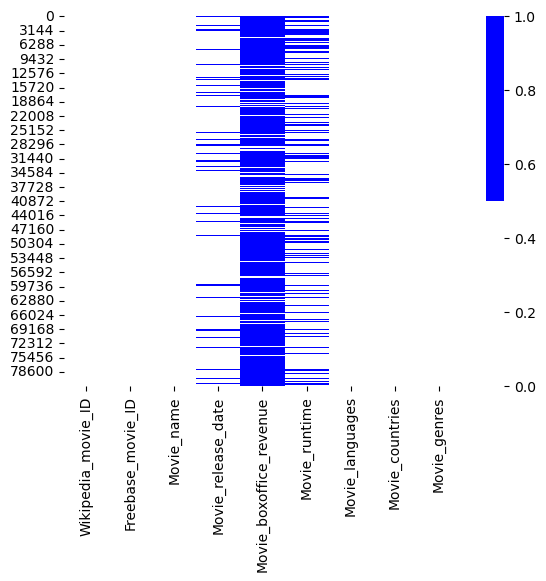

In [5]:
movie_md.info()
sns.heatmap(movie_md.isnull(), cmap=['w','b'])
plt.show()

**Create relational tables for languages, countries and genres**

In [6]:
def string2list(string):
    '''
    Converts string to dictionnary to list
    in order to be able to use pandas.DataFrame.explode()
    '''
    import ast
    
    dic = ast.literal_eval(string)
    new_list  = list(dic.values())
    return new_list


movie_languages = movie_md.copy()
movie_languages.Movie_languages = movie_languages.Movie_languages.apply(lambda x: string2list(x))
movie_languages = movie_languages.explode('Movie_languages', ignore_index = True)
movie_languages = movie_languages.drop(columns=['Freebase_movie_ID', 'Movie_name','Movie_release_date'\
                                                ,'Movie_boxoffice_revenue','Movie_runtime','Movie_countries'\
                                                ,'Movie_genres'])
movie_languages['Movie_languages']= movie_languages['Movie_languages'].astype(str) 

movie_countries = movie_md.copy()
movie_countries['Movie_countries'] = movie_countries['Movie_countries'].apply(lambda x: string2list(x))
movie_countries = movie_countries.explode('Movie_countries', ignore_index = True)
movie_countries = movie_countries.drop(columns=['Freebase_movie_ID', 'Movie_name','Movie_release_date'\
                                                ,'Movie_boxoffice_revenue','Movie_runtime','Movie_languages'\
                                                ,'Movie_genres'])

movie_genres = movie_md.copy()
movie_genres['Movie_genres'] = movie_genres['Movie_genres'].apply(lambda x: string2list(x))
movie_genres = movie_genres.explode('Movie_genres', ignore_index = True)
movie_genres = movie_genres.drop(columns=['Freebase_movie_ID', 'Movie_name','Movie_release_date'\
                                                ,'Movie_boxoffice_revenue','Movie_runtime','Movie_languages'\
                                                ,'Movie_countries'])
movie_genres

,Wikipedia_movie_ID,Movie_genres
0,975900,Thriller
1,975900,Science Fiction
2,975900,Horror
3,975900,Adventure
4,975900,Supernatural
...,...,...
245618,913762,Drama
245619,12476867,Thriller
245620,12476867,Horror
245621,12476867,Slasher


**Clean + distribution of Movie_release_date**

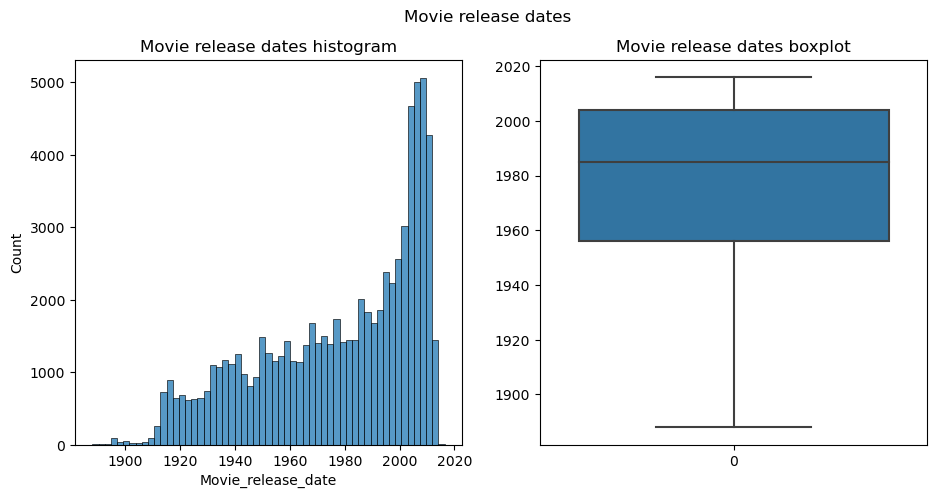

count                            74838
mean     1977-10-12 11:46:07.610037696
min                1888-01-01 00:00:00
25%                1956-01-01 00:00:00
50%                1985-05-18 12:00:00
75%                2004-01-01 00:00:00
max                2016-06-08 00:00:00
Name: Movie_release_date, dtype: object

In [7]:
#movie_md[movie_md.Movie_release_date.isna()]#all missing Movie_release_date are nan

#convert dates to datetimes. Dates with only year are set as the first of January of that year. Date that are out of bounds
#are set as NaT.
movie_md.Movie_release_date = pd.to_datetime(movie_md.Movie_release_date, errors = 'coerce', yearfirst = True)

fig = plt.figure(figsize=[11, 5])
plt.suptitle('Movie release dates')

# Plot 1
plt.subplot(1, 2, 1)
sns.histplot(data=movie_md, x='Movie_release_date')
plt.title('Movie release dates histogram')

# Plot 2
plt.subplot(1, 2, 2)
sns.boxplot(data=movie_md.Movie_release_date.dt.year)
plt.title('Movie release dates boxplot')
plt.show()

fig.savefig('figures_project/hist_release_date.png',bbox_inches='tight',dpi=400)


movie_md.Movie_release_date.describe(datetime_is_numeric = True)

There doesn't seem to be any major issues with the movie release dates. Although the earliest movie from the dataset is from 1888 (which raised suspicion) and lasts only 3 seconds, after some research, it is in fact a real 'film'.

**Clean + distribution of Movie_boxoffice_revenue**

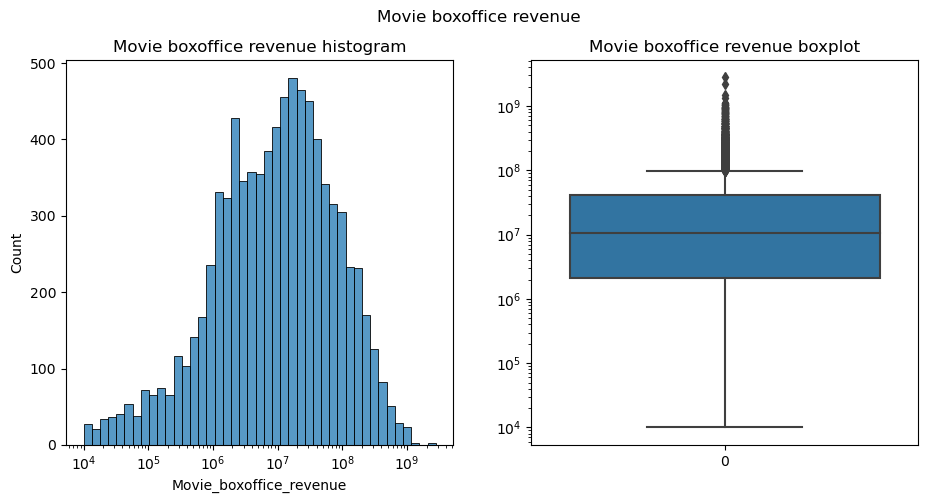

Max revenue: count    8.401000e+03
mean     4.799363e+07
std      1.121753e+08
min      1.000000e+04
25%      2.083193e+06
50%      1.063969e+07
75%      4.071696e+07
max      2.782275e+09
Name: Movie_boxoffice_revenue, dtype: float64


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_boxoffice_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


In [8]:
#movie_md[movie_md.Movie_boxoffice_revenue.isna()]#all missing Movie_release_date are nan

fig = plt.figure(figsize=[11, 5])
plt.suptitle('Movie boxoffice revenue')

# Plot 1
plt.subplot(1, 2, 1)
sns.histplot(data=movie_md, x='Movie_boxoffice_revenue',log_scale = True)
plt.title('Movie boxoffice revenue histogram')

# Plot 2
plt.subplot(1, 2, 2)
sns.boxplot(data=movie_md.Movie_boxoffice_revenue)
plt.yscale('log')
plt.title('Movie boxoffice revenue boxplot')
plt.show()
fig.savefig('figures_project/hist_box_office_revenue.png',bbox_inches='tight',dpi=400)

stats = movie_md.Movie_boxoffice_revenue.describe()
print(f'Max revenue: {stats}')
movie_md.loc[movie_md.Movie_boxoffice_revenue == stats[7]]#highest movie boxoffice is real, not 'dirty data' 

**Clean + distribution of Movie_runtime**

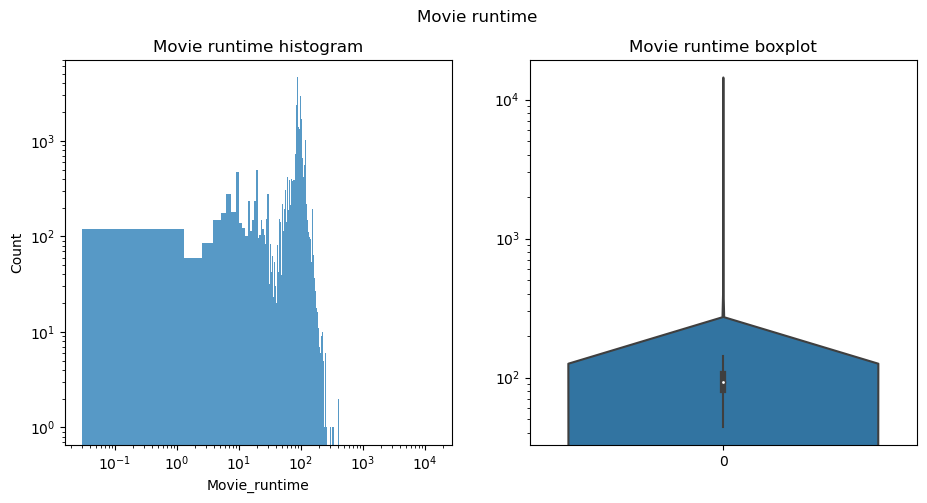

count    61289.000000
mean        94.213130
std         91.297088
min          0.030000
25%         81.000000
50%         93.000000
75%        106.000000
max      14400.000000
Name: Movie_runtime, dtype: float64

In [9]:
#movie_md[movie_md.Movie_runtime.isna()]#all missing Movie_release_date are nan

#replace the max and min movie runtime which are wrong values.
movie_md.loc[movie_md.Movie_runtime == np.max(movie_md.Movie_runtime), 'Movie_runtime'] = np.nan #wrong max 
movie_md.loc[movie_md.Movie_runtime == np.min(movie_md.Movie_runtime), 'Movie_runtime'] = np.nan #wrong min

fig = plt.figure(figsize=[11, 5])
plt.suptitle('Movie runtime')

# Plot 1
plt.subplot(1, 2, 1)
sns.histplot(data=movie_md, x='Movie_runtime')
plt.yscale('log')
plt.xscale('log')
plt.title('Movie runtime histogram')

# Plot 2
plt.subplot(1, 2, 2)
sns.violinplot(data=movie_md.Movie_runtime)
plt.yscale('log')
plt.title('Movie runtime boxplot')
plt.show()

fig.savefig('figures_project/hist_bmovie_runtime.png',bbox_inches='tight',dpi=400)


movie_md.Movie_runtime.describe()

stats = movie_md.Movie_runtime.describe()
stats

**Clean + distributions of movie_languages**

In [10]:
#One problematic false movie language:'\ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32' that still
#has to be dealt with. The lines below are just some tests that were done to try an resolve the issue, without success

#unique = pd.DataFrame(movie_languages.Movie_languages.unique())
#unique.sample(60)
#From the line above, problematic language value: \ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32
#unique[unique == 'English Language']
#unique[unique[0] == '\ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32']
#'utf-8' codec can't encode characters in position 97-108: surrogates not allowed
#oui = unique == '\ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32'

#non = oui[0].tolist()
#non.index(True)
#unique.iloc[82]

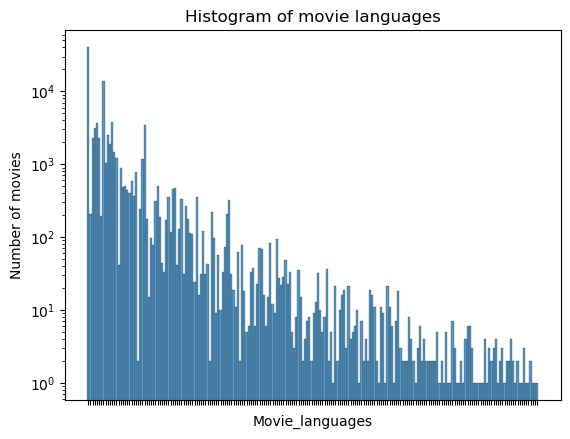

,Number_movies,Ratio,Cumsum
Movie_languages,,,
English Language,40891,42.965368,42.965368
nan,13866,14.569411,57.534779
Hindi Language,3744,3.933930,61.468709
Spanish Language,3673,3.859328,65.328038
French Language,3422,3.595595,68.923633
Silent film,3183,3.344471,72.268104
Italian Language,2531,2.659396,74.927500
Japanese Language,2295,2.411424,77.338923
German Language,2258,2.372547,79.711470


In [11]:
#histogram of all movie languages (without labels as unreadable otherwise)
plt.figure()
g = sns.histplot(data=movie_languages, x='Movie_languages')
g.set(xticklabels=[])
g.set_title('Histogram of movie languages')
g.set_ylabel('Number of movies')
plt.yscale('log')
plt.show()

#make sorted table of movie languages with the number of movies in that language, it's propotion relative to the other
#movies + cumulative proportion (cumsum)
number_movie_languages_sorted = movie_languages.groupby(by = 'Movie_languages').count().sort_values(
                                                            by = 'Wikipedia_movie_ID', ascending = False)
number_movie_languages_sorted = number_movie_languages_sorted.rename(columns = {'Wikipedia_movie_ID': 'Number_movies'})
tot_movies_languages = number_movie_languages_sorted.sum()
number_movie_languages_sorted['Ratio'] = number_movie_languages_sorted*100/tot_movies_languages
number_movie_languages_sorted['Cumsum'] = number_movie_languages_sorted['Ratio'].cumsum()

number_movie_languages_sorted.head(10)

**Clean + distributions of movie_countries**

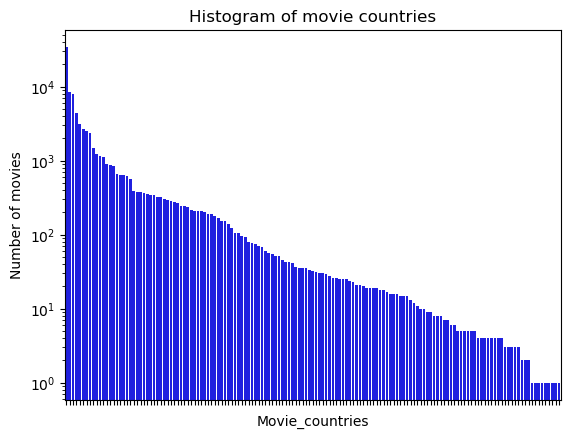

147

In [12]:
movie_countries.Movie_countries.unique()

#make sorted table of movie countires with the number of movies from that country, it's propotion relative to the other
#movies + cumulative proportion (cumsum)
number_movie_countries_sorted = movie_countries.groupby(by = 'Movie_countries').count().sort_values(
                                                            by = 'Wikipedia_movie_ID', ascending = False)
number_movie_countries_sorted = number_movie_countries_sorted.rename(columns = {'Wikipedia_movie_ID': 'Number_movies'})
tot_movies_countries = number_movie_countries_sorted.sum()

number_movie_countries_sorted['Ratio'] = number_movie_countries_sorted*100/tot_movies_countries
number_movie_countries_sorted['Cumsum'] = number_movie_countries_sorted['Ratio'].cumsum()

#barplot of all movie countries (without labels as unreadable otherwise)
plt.figure()
g = sns.barplot(data = number_movie_countries_sorted, x = number_movie_countries_sorted.index , y = 'Number_movies', color = 'b')
g.set(xticklabels=[])
g.set_title('Histogram of movie countries')
g.set_ylabel('Number of movies')
plt.yscale('log')
plt.show()

len(number_movie_countries_sorted)

**Clean + distributions of movie_genres**

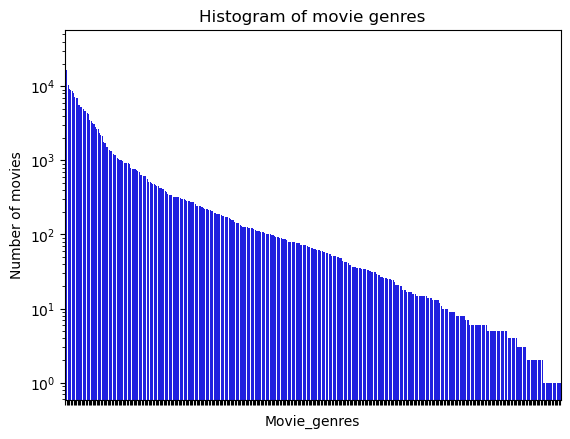

,Number_movies,Ratio,Cumsum
Movie_genres,,,
Drama,34007,13.975728,13.975728
Comedy,16349,6.718887,20.694615
Romance Film,10234,4.205828,24.900443
Black-and-white,9094,3.737327,28.637770
Action,8798,3.615681,32.253451
Thriller,8744,3.593489,35.846940
Short Film,8141,3.345676,39.192616
World cinema,7155,2.940463,42.133079
Crime Fiction,6948,2.855393,44.988472


In [13]:
movie_genres.Movie_genres.unique()

#replace Biopic [feature] by Biopic
movie_genres.loc[movie_genres.Movie_genres == 'Biopic [feature]','Movie_genres'] = 'Biopic'

#make sorted table of movie genres with the number of movies from that genre, it's propotion relative to the other
#movies + cumulative proportion (cumsum)
number_movie_genres_sorted = movie_genres.groupby(by = 'Movie_genres').count().sort_values(
                                                            by = 'Wikipedia_movie_ID', ascending = False)
number_movie_genres_sorted = number_movie_genres_sorted.rename(columns = {'Wikipedia_movie_ID': 'Number_movies'})
tot_movies_genres = number_movie_genres_sorted.sum()

number_movie_genres_sorted['Ratio'] = number_movie_genres_sorted*100/tot_movies_genres
number_movie_genres_sorted['Cumsum'] = number_movie_genres_sorted['Ratio'].cumsum()

#histogram of all movie genres (without labels as unreadable otherwise)
plt.figure()
g = sns.barplot(data = number_movie_genres_sorted, x = number_movie_genres_sorted.index , y = 'Number_movies', color = 'b')
g.set(xticklabels=[])
plt.yscale('log')
g.set_title('Histogram of movie genres')
g.set_ylabel('Number of movies')
plt.show()

#Display dataframe
number_movie_genres_sorted.head(10)

## 1.4 character.metadata.tsv.gz (dataset 4)

Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [14]:
#Import dataset
colnames=['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name','Actor_date_of_birth', 'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID'] 

character_md = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t',names = colnames, header=None)
character_md.head(5)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Data cleaning

In [15]:
#Have an idea about the type of data
character_md.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia_movie_ID               450669 non-null  int64  
 1   Freebase_movie_ID                450669 non-null  object 
 2   Movie_release_date               440674 non-null  object 
 3   Character_name                   192794 non-null  object 
 4   Actor_date_of_birth              344524 non-null  object 
 5   Actor_gender                     405060 non-null  object 
 6   Actor_height                     154824 non-null  float64
 7   Actor_ethnicity                  106058 non-null  object 
 8   Actor_name                       449441 non-null  object 
 9   Actor_age_at_movie_release       292556 non-null  float64
 10  Freebase_character/actor_map_ID  450669 non-null  object 
 11  Freebase_character_ID            192804 non-null  object 
 12  Fr

<AxesSubplot:>

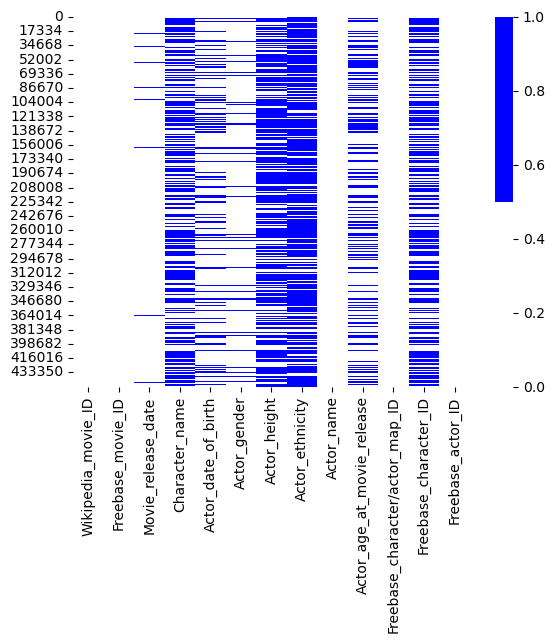

In [16]:
#Heatmap to see the presence of NaN
sns.heatmap(character_md.isnull(),cmap=['w','b'])

For some columns, such as "Wikipedia_movie_ID", "Freebase_movie_ID", "Actor_name", and "Freebase_character/actor_map_ID", and "Freebase_actor_ID", there are no NaN values (or too little). Whereas for other columns, such as "Actor_ethnicity", it seems that there more missing values than proper information.

In [17]:
#See quantitatively the number of NaN per column
print(f'There are {len(character_md)} rows')
for i in range(0,len(character_md.columns)):
    nans = character_md.iloc[:,i].isnull().sum()
    print(f'Column {character_md.columns[i]} has: \n\t {nans} NaNs \n \t {nans/len(character_md)*100}% of the rows with NaN\n')

There are 450669 rows
Column Wikipedia_movie_ID has: 
	 0 NaNs 
 	 0.0% of the rows with NaN

Column Freebase_movie_ID has: 
	 0 NaNs 
 	 0.0% of the rows with NaN

Column Movie_release_date has: 
	 9995 NaNs 
 	 2.217813961022391% of the rows with NaN

Column Character_name has: 
	 257875 NaNs 
 	 57.22048776374679% of the rows with NaN

Column Actor_date_of_birth has: 
	 106145 NaNs 
 	 23.552762670607475% of the rows with NaN

Column Actor_gender has: 
	 45609 NaNs 
 	 10.120287838746398% of the rows with NaN

Column Actor_height has: 
	 295845 NaNs 
 	 65.64573999986688% of the rows with NaN

Column Actor_ethnicity has: 
	 344611 NaNs 
 	 76.46654196317031% of the rows with NaN

Column Actor_name has: 
	 1228 NaNs 
 	 0.2724837963117055% of the rows with NaN

Column Actor_age_at_movie_release has: 
	 158113 NaNs 
 	 35.08406391387027% of the rows with NaN

Column Freebase_character/actor_map_ID has: 
	 0 NaNs 
 	 0.0% of the rows with NaN

Column Freebase_character_ID has: 
	 25786

We see indeed that 76.46654196317031% of the rows of "Actor_ethnicity" have NaN.

For the gender analysis, we create a dataset that discards rows containing NaN for 'Actor_gender' 

In [18]:
character_md_gender = character_md[character_md['Actor_gender'].notna()]
print(f'{character_md.iloc[:,5].isnull().sum()} rows are discarded.\n This corresponds to {character_md.iloc[:,5].isnull().sum()/len(character_md)*100}% of the rows')

45609 rows are discarded.
 This corresponds to 10.120287838746398% of the rows


In [19]:
#create a copy of character_md_gender, that will be used in the analysis
character_gender = character_md_gender.copy()

character_gender.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Some numbers and statistics

In [20]:
nb_women = character_gender[character_gender.Actor_gender == 'F'].shape[0]
nb_women
print(f'{nb_women/len(character_gender)*100}% of all the actors of the dataset are women')

33.27976102305831% of all the actors of the dataset are women


In [21]:
#convert the column 'Movie_release_date' from object to datetime type
character_gender['Movie_release_date'] = pd.to_datetime(character_gender['Movie_release_date'], errors = 'coerce')

In [22]:
character_gender.dtypes

Wikipedia_movie_ID                          int64
Freebase_movie_ID                          object
Movie_release_date                 datetime64[ns]
Character_name                             object
Actor_date_of_birth                        object
Actor_gender                               object
Actor_height                              float64
Actor_ethnicity                            object
Actor_name                                 object
Actor_age_at_movie_release                float64
Freebase_character/actor_map_ID            object
Freebase_character_ID                      object
Freebase_actor_ID                          object
dtype: object

In [23]:
#create new column containing only the year: Movie_year
character_gender['Movie_year'] = character_gender['Movie_release_date'].dt.year
character_gender.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0


Text(0, 0.5, 'Number of actors/actresses')

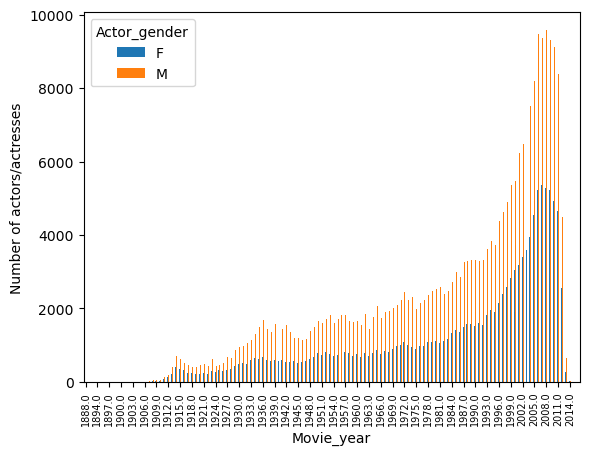

In [24]:
#Plot histogram of number of actor and actresses per year
character_gender.pivot_table(index=['Movie_year'],columns='Actor_gender',aggfunc='size').plot(kind='bar')
ax = plt.gca()
ax.set_xticks(ax.get_xticks()[::3])
ax.xaxis.set_tick_params(labelsize=7)
ax.set_ylabel('Number of actors/actresses')

We can clearly see that the number of men cast per year surpasses the number of women for almost all the years

## 1.5 tvtropes.clusters.txt (dataset 5)

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

First of all, the text document is read into a dataframe with tabstop as separator. Further manipulations are performed in order to have a well-arranged dataframe including all necessary information.

In [25]:
# create dataframe by reading the textfile with tabstop as separator
colnames = ['character_type', 'description'] 

df_tvtropes = pd.read_csv('data/MovieSummaries/tvtropes.clusters.txt',
                          names = colnames, header = None, sep="\t", on_bad_lines='warn')

In [26]:
# split column "description" of the df in further columns "char", "movie", "id", and "actor"
df_tvtropes.description=df_tvtropes['description'].str.replace("{" ,"",regex=True)
df_tvtropes.description=df_tvtropes['description'].str.replace("}" ,"",regex=True)

# new data frame with split value columns
new = df_tvtropes["description"].str.split('", "|": "', expand=True)
 
# add to existing dataframe
df_tvtropes["char"]= new[1]
df_tvtropes["movie"]= new[3]
df_tvtropes["id"]=new[5]
df_tvtropes["actor"]=new[7]

df_tvtropes['actor']=df_tvtropes['actor'].str.replace('"' ,'',regex=True)
 
# Drop old column "description"
df_tvtropes.drop(columns =["description"], inplace = True)

# Merge with Character Metadata to get gender of actor
df_tvtropes = pd.merge(df_tvtropes, character_md[['Freebase_character/actor_map_ID','Actor_gender']],
                       left_on='id', right_on='Freebase_character/actor_map_ID', how='left')

# create column with release year only
#df_tvtropes['Movie_release_date'] = pd.to_datetime(df_tvtropes['Movie_release_date'], errors = 'coerce')
#df_tvtropes['Movie_year'] = df_tvtropes['Movie_release_date'].dt.year.fillna(0.0).astype(int)
  
# display df
df_tvtropes

,character_type,char,movie,id,actor,Freebase_character/actor_map_ID,Actor_gender
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,/m/0jy9q0,M
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,/m/02vchl3,M
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,/m/0k6fkc,M
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,/m/0k6_br,M
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,/m/0k3rhh,M
...,...,...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton,/m/0k776f,M
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson,/m/0k2kqg,M
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West,/m/0k5nsh,M
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez,/m/03lrjk0,M


In [27]:
# check if there is any NaN value
df_tvtropes.isnull().any()

character_type                     False
char                               False
movie                              False
id                                 False
actor                              False
Freebase_character/actor_map_ID    False
Actor_gender                        True
dtype: bool

The dataframe is grouped by character types in order to investigate the most prevalent types.

In [28]:
df_tvtropes_grouped = df_tvtropes.groupby(['character_type'])['character_type'].count().\
                        to_frame(name='nb_movies').reset_index()
df_tvtropes_grouped = df_tvtropes_grouped.sort_values(by='nb_movies', ascending=False).reset_index()
df_tvtropes_grouped.drop(columns =["index"], inplace = True)

In [29]:
print('These are the 10 most prevalent character types:')
for i in range(10):
    print(f"{i+1}. {df_tvtropes_grouped['character_type'][i]} (in {df_tvtropes_grouped['nb_movies'][i]} movies)")

These are the 10 most prevalent character types:
1. crazy_jealous_guy (in 25 movies)
2. corrupt_corporate_executive (in 23 movies)
3. byronic_hero (in 17 movies)
4. psycho_for_hire (in 16 movies)
5. father_to_his_men (in 15 movies)
6. stoner (in 13 movies)
7. brainless_beauty (in 12 movies)
8. master_swordsman (in 12 movies)
9. dumb_blonde (in 11 movies)
10. slacker (in 11 movies)


For the analysis, the dataframe is divided into two dataframes. One conains all instances with a woman as an actress, the other one with men.

In [30]:
# create separate dfs by gender
df_tvtropes_M = df_tvtropes[df_tvtropes['Actor_gender']=='M']
df_tvtropes_F = df_tvtropes[df_tvtropes['Actor_gender']=='F']
print(f'Number of tvtropes for a female actor: {df_tvtropes_F.shape[0]}')
print(f'Number of tvtropes for a male actor: {df_tvtropes_M.shape[0]}')
print(f"Number of tvtropes where gender of actor/actress could not be identified:\
 {df_tvtropes[df_tvtropes['Actor_gender'].isnull()].shape[0]} -> this instance will not be considered for further analysis")

Number of tvtropes for a female actor: 69
Number of tvtropes for a male actor: 431
Number of tvtropes where gender of actor/actress could not be identified: 1 -> this instance will not be considered for further analysis


# Part 1 - Gender inequality in the movie industry - Preparation of dataframes for further analysis

## Question 1.1: What is the global trend of number of women and men cast in movies?

In [32]:
#Look at the dataframe that will be used to create other dataframes in this section
character_gender.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0


**Number of males and females in each movie**

In [33]:
#We want to get a dataframe with one movie per row, showing its year, nb of men, nb of women, 
#and female share (nb_women/(nb_men+nb_women))

#Do a copy of character_gender, so that the copy can be used to create grouped versions
grouped_gender = character_gender.copy()

#Select columns of interest
grouped_gender = grouped_gender[['Wikipedia_movie_ID','Actor_gender', 'Movie_year']]

#Count the number of female/male actors for each movie (group per movie)
#this is done by creating two new dataframes (for F and M)
grouped_gender_F = grouped_gender.loc[grouped_gender.Actor_gender == 'F']
grouped_gender_F_movie = grouped_gender_F.groupby(['Wikipedia_movie_ID','Movie_year']).count()
grouped_gender_F_movie = grouped_gender_F_movie.rename(columns = {'Actor_gender':'Female'}).sort_values(by = 'Movie_year')

grouped_gender_M = grouped_gender.loc[grouped_gender.Actor_gender == 'M']
grouped_gender_M_movie = grouped_gender_M.groupby(['Wikipedia_movie_ID','Movie_year']).count()
grouped_gender_M_movie = grouped_gender_M_movie.rename(columns = {'Actor_gender':'Male'}).sort_values(by = 'Movie_year')

#Merge the two dataframes with number of males and females for each movie
grouped_gender_movie = pd.merge(grouped_gender_F_movie, grouped_gender_M_movie, on = ['Wikipedia_movie_ID', 'Movie_year'], how = 'outer')
grouped_gender_movie = grouped_gender_movie.fillna(0)

#Create Female_share: metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_movie['Female_share'] = grouped_gender_movie.Female/(grouped_gender_movie.Female + grouped_gender_movie.Male)
grouped_gender_movie = grouped_gender_movie.reset_index()
grouped_gender_movie.head(5)


,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share
0,1082508,1888.0,2.0,2.0,0.5
1,7669437,1894.0,1.0,0.0,1.0
2,807258,1896.0,3.0,0.0,1.0
3,4062042,1896.0,1.0,1.0,0.5
4,436308,1896.0,1.0,1.0,0.5


**Number of males and females cast per year**

In [40]:
#Here, we are no longer interested in each movie individually, but in the Female_share per year
#reset grouped_gender
grouped_gender = character_gender.copy()
#Select columns of interest:
grouped_gender = grouped_gender[['Actor_gender', 'Movie_year']]


#Do the same procedure as before, this time grouping by year instead of movie
#Count the number of female/male actors for each year
grouped_gender_F = grouped_gender.loc[grouped_gender.Actor_gender == 'F']
grouped_gender_F_year = grouped_gender_F.groupby(['Movie_year']).count()
grouped_gender_F_year = grouped_gender_F_year.rename(columns = {'Actor_gender':'Female'})

grouped_gender_M = grouped_gender.loc[grouped_gender.Actor_gender == 'M']
grouped_gender_M_year = grouped_gender_M.groupby(['Movie_year']).count()
grouped_gender_M_year = grouped_gender_M_year.rename(columns = {'Actor_gender':'Male'})

#Merge the number of males and females for each year
grouped_gender_year = pd.merge(grouped_gender_F_year, grouped_gender_M_year, on = ['Movie_year'], how = 'outer')
grouped_gender_year = grouped_gender_year.fillna(0)
grouped_gender_year = grouped_gender_year.sort_index()

#Create Female_share, metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_year['Female_share'] = grouped_gender_year.Female/(grouped_gender_year.Female + grouped_gender_year.Male)
grouped_gender_year = grouped_gender_year.reset_index()

grouped_gender_year

,Movie_year,Female,Male,Female_share
0,1888.0,2.0,2,0.500000
1,1891.0,0.0,1,0.000000
2,1893.0,0.0,2,0.000000
3,1894.0,1.0,3,0.250000
4,1895.0,0.0,1,0.000000
...,...,...,...,...
121,2012.0,2545.0,4502,0.361147
122,2013.0,281.0,643,0.304113
123,2014.0,15.0,21,0.416667
124,2015.0,2.0,12,0.142857


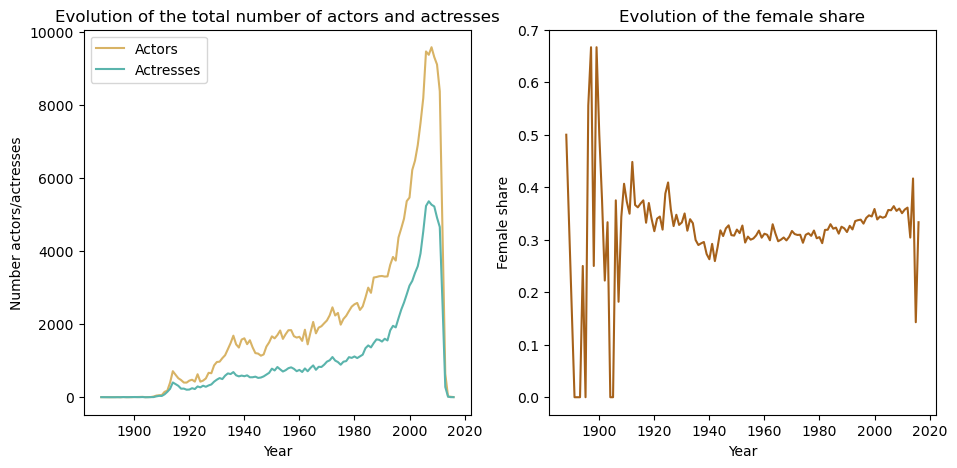

In [49]:
fig = plt.figure(figsize=[11, 5])

# Plot 1
plt.subplot(1, 2, 1)
sns.lineplot(grouped_gender_year.Movie_year, grouped_gender_year.Male, label = 'Actors', color ='#d8b365')
sns.lineplot(grouped_gender_year.Movie_year, grouped_gender_year.Female, label = 'Actresses', color = '#5ab4ac')
plt.title('Evolution of the total number of actors and actresses')
plt.xlabel('Year')
plt.ylabel('Number actors/actresses')


# Plot 2
plt.subplot(1, 2, 2)
sns.lineplot(grouped_gender_year.Movie_year, grouped_gender_year.Female_share, color = '#a6611a')
plt.xlabel('Year')
plt.ylabel('Female share')
plt.title('Evolution of the female share')
plt.show()

fig.savefig('figures_project/number-FS_evolution.png',bbox_inches='tight',dpi=400)


## Question 1.2

**Calculate female share per country**

In [35]:
#Now, we are interested in the Female_share per country:
#we will group by country, with the same procedure as before
grouped_gender = character_gender.copy()
grouped_gender = grouped_gender[['Wikipedia_movie_ID','Actor_gender','Movie_year']]

In [36]:
#merge grouped_gender with the dataset containing countries (movie_countries), created at the data cleaning of dataset 3
#using movie_ID as common attribute
grouped_gender_country = pd.merge(grouped_gender, movie_countries, on = ['Wikipedia_movie_ID'], how = 'outer')
grouped_gender_country.head()

,Wikipedia_movie_ID,Actor_gender,Movie_year,Movie_countries
0,975900,F,2001.0,United States of America
1,975900,F,2001.0,United States of America
2,975900,M,2001.0,United States of America
3,975900,M,2001.0,United States of America
4,975900,F,2001.0,United States of America


In [36]:
del grouped_gender_country['Wikipedia_movie_ID'], grouped_gender_country['Movie_year']

#Count the number of female/male actors for each country
grouped_gender_F = grouped_gender_country.loc[grouped_gender_country.Actor_gender == 'F']
grouped_gender_F_country = grouped_gender_F.groupby(['Movie_countries']).count()
grouped_gender_F_country = grouped_gender_F_country.rename(columns = {'Actor_gender':'Female'})

grouped_gender_M = grouped_gender_country.loc[grouped_gender_country.Actor_gender == 'M']
grouped_gender_M_country = grouped_gender_M.groupby(['Movie_countries']).count()
grouped_gender_M_country = grouped_gender_M_country.rename(columns = {'Actor_gender':'Male'})

#Merge the number of males and females for each country
grouped_gender_country = pd.merge(grouped_gender_F_country, grouped_gender_M_country, on = ['Movie_countries'], how = 'outer')
grouped_gender_country = grouped_gender_country.fillna(0)

#Create metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_country['Female_share'] = grouped_gender_country.Female/(grouped_gender_country.Female + grouped_gender_country.Male)

In [37]:
grouped_gender_country=grouped_gender_country.reset_index()
grouped_gender_country.head()

,Movie_countries,Female,Male,Female_share
0,Afghanistan,23.0,34.0,0.403509
1,Albania,17.0,46.0,0.269841
2,Algeria,32.0,89.0,0.264463
3,Argentina,797.0,1503.0,0.346522
4,Armenia,8.0,11.0,0.421053


**Plot countries on a map with Female_share**

We want to show on a map what is the Female_share for the top 10 movie-producing countries. For this, two functions are created: one to obtain the country code and another to get latitute and latitute of the country.

In [38]:
#function to convert to alpah2 country codes and continents
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_continent)

In [39]:
#function to get longitude and latitude data from country name
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

In [40]:
#select top 10 movie-producing countries from a dataset created in cleaning, part 1.3
top_10 = number_movie_countries_sorted.head(10).reset_index()
top_10

#Get top 4 movie-producing countries 
top_4 = top_10.Movie_countries[0:4].tolist()

In [41]:
grouped_gender_country_10 = grouped_gender_country.copy()
#We update top_10 such that it contains the Female_share for the top 10 movie-producing countries
top_10 = grouped_gender_country_10[(grouped_gender_country_10.Movie_countries.isin(top_10.Movie_countries))]
top_10

,Movie_countries,Female,Male,Female_share
3,Argentina,797.0,1503.0,0.346522
21,Canada,5476.0,9738.0,0.359932
40,France,8829.0,15547.0,0.362201
45,Germany,4984.0,10174.0,0.328803
48,Hong Kong,1973.0,4936.0,0.285570
51,India,15622.0,29872.0,0.343386
58,Italy,4700.0,9245.0,0.337038
60,Japan,4541.0,7948.0,0.363600
127,United Kingdom,15396.0,32386.0,0.322213
128,United States of America,72632.0,151461.0,0.324115


In [42]:
#Call the get_continent function, in order to find country codes
#Country codes will be required to find latitude and longitude 
top_10['Country_code']='0'
for i in range(0,len(top_10)):
    top_10.iloc[i,4]=get_continent(top_10.iloc[i,0])[0]

In [43]:
top_10

,Movie_countries,Female,Male,Female_share,Country_code
3,Argentina,797.0,1503.0,0.346522,AR
21,Canada,5476.0,9738.0,0.359932,CA
40,France,8829.0,15547.0,0.362201,FR
45,Germany,4984.0,10174.0,0.328803,DE
48,Hong Kong,1973.0,4936.0,0.285570,HK
51,India,15622.0,29872.0,0.343386,IN
58,Italy,4700.0,9245.0,0.337038,IT
60,Japan,4541.0,7948.0,0.363600,JP
127,United Kingdom,15396.0,32386.0,0.322213,GB
128,United States of America,72632.0,151461.0,0.324115,US


In [44]:
#Run the function above and split geolocate into two separate latitude and longitude columns
top_10[['Latitude','Longitude']]=[0,0]
for i in range(0,len(top_10)):
    top_10.iloc[i,5]=geolocate(top_10.iloc[i,4])[0]
    top_10.iloc[i,6]=geolocate(top_10.iloc[i,4])[1]

In [132]:
top_10.head(10)

,Movie_countries,Female,Male,Female_share,Country_code,Latitude,Longitude
3,Argentina,797.0,1503.0,0.346522,AR,-34.996496,-64.967282
21,Canada,5476.0,9738.0,0.359932,CA,61.066692,-107.991707
40,France,8829.0,15547.0,0.362201,FR,46.603354,1.888334
45,Germany,4984.0,10174.0,0.328803,DE,51.163818,10.447831
48,Hong Kong,1973.0,4936.0,0.285570,HK,22.350627,114.184916
51,India,15622.0,29872.0,0.343386,IN,22.351115,78.667743
58,Italy,4700.0,9245.0,0.337038,IT,42.638426,12.674297
60,Japan,4541.0,7948.0,0.363600,JP,36.574844,139.239418
127,United Kingdom,15396.0,32386.0,0.322213,GB,54.702354,-3.276575
128,United States of America,72632.0,151461.0,0.324115,US,39.783730,-100.445882


In [131]:
# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(top_10)):
    lat = top_10.iloc[i]['Latitude']
    long = top_10.iloc[i]['Longitude']
    #Use exponential to be able to see a difference between circles
    radius=np.exp(top_10.iloc[i,3]*10)
    popup_text = """Country : {}<br>
                 Share of female in movies: {}<br>"""
    popup_text = popup_text.format(top_10.iloc[i]['Country_code'],
                                   top_10.iloc[i]['Female_share'])
    folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map
#since this map is interactive, it is, unfortunately, not possible to show it in this first milestone
#therefore, this map will be present in our final data-story
#It will be possible to zoom in, and, by clicking on the country circle, see the country code, and its share of female in movies.

## Question 1.3

**Look at Female_share per movie genres**

In [47]:
#Dataframe previously created in the cleaning part (1.3)
#It is grouped by movie_genres
number_movie_genres_sorted

,Number_movies,Ratio,Cumsum
Movie_genres,,,
Drama,34007,13.975728,13.975728
Comedy,16349,6.718887,20.694615
Romance Film,10234,4.205828,24.900443
Black-and-white,9094,3.737327,28.637770
Action,8798,3.615681,32.253451
...,...,...,...
Comdedy,1,0.000411,99.998356
New Queer Cinema,1,0.000411,99.998767
Linguistics,1,0.000411,99.999178


In [48]:
#Create a new dataframe "genres_gender" by merging movie_genres and character_gender
genres_gender = pd.merge(movie_genres, character_gender, on = ['Wikipedia_movie_ID'], how = 'outer')
genres_gender = genres_gender[['Movie_genres','Actor_gender']]
genres_gender.sample(5)

,Movie_genres,Actor_gender
1286777,Action/Adventure,M
249789,Drama,M
413562,Parody,F
54760,Action/Adventure,F
1450770,Adventure,F


In [49]:
#Same procedure done before:
#Count the number of female/male actors for each year
grouped_gender_F = genres_gender.loc[genres_gender.Actor_gender == 'F']
grouped_gender_F_genres = grouped_gender_F.groupby(['Movie_genres']).count()
grouped_gender_F_genres = grouped_gender_F_genres.rename(columns = {'Actor_gender':'Female'})

grouped_gender_M = genres_gender.loc[genres_gender.Actor_gender == 'M']
grouped_gender_M_genres = grouped_gender_M.groupby(['Movie_genres']).count()
grouped_gender_M_genres = grouped_gender_M_genres.rename(columns = {'Actor_gender':'Male'})

#Merge the number of males and females for each year
grouped_gender_genres = pd.merge(grouped_gender_F_genres, grouped_gender_M_genres, on = ['Movie_genres'], how = 'outer')
grouped_gender_genres = grouped_gender_genres.fillna(0)
grouped_gender_genres = grouped_gender_genres.sort_index()

#Create metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_genres['Female_share'] = grouped_gender_genres.Female/(grouped_gender_genres.Female + grouped_gender_genres.Male)
grouped_gender_genres = grouped_gender_genres.reset_index()

#grouped_gender_genres is a dataframe with Female_share per each movie genre
grouped_gender_genres.sort_values(by='Female_share',ascending=False).head()

,Movie_genres,Female,Male,Female_share
289,Romantic thriller,1.0,0.0,1.000000
177,Health & Fitness,12.0,6.0,0.666667
347,War effort,2.0,1.0,0.666667
352,Women in prison films,64.0,39.0,0.621359
254,Pinku eiga,44.0,28.0,0.611111


Now we create a dataframe containing one movie per row, with respective female_share and genre. This will be useful for merging all precedent datasets in Q1.5

In [50]:
#add movie genres to the dataframe "grouped_gender_movie" created at Q1.1
#this is done by merging the datframes grouped_gender_movie with movie_genres 
#(created at 1.3 of Data cleaning part)
grouped_movie_genre_gender = pd.merge(grouped_gender_movie, movie_genres, on = ['Wikipedia_movie_ID'], how = 'outer')
grouped_movie_genre_gender.head()

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_genres
0,1082508,1888.0,2.0,2.0,0.5,Short Film
1,1082508,1888.0,2.0,2.0,0.5,Silent film
2,1082508,1888.0,2.0,2.0,0.5,Indie
3,1082508,1888.0,2.0,2.0,0.5,Black-and-white
4,7669437,1894.0,1.0,0.0,1.0,Short Film


## Question 1.4

In [51]:
#Creation of dataframe to be used for question 2
actor = character_gender.copy()

#Keep only columns of interest
actor = actor[['Wikipedia_movie_ID', 'Movie_year', 'Actor_gender','Actor_ethnicity',
                                     'Actor_name', 'Actor_age_at_movie_release', 'Freebase_actor_ID']]

#Aggregate rows on actor_ID, perform various functions on the other columns
actor = actor.groupby(by = 'Freebase_actor_ID').agg({'Wikipedia_movie_ID': 'count', 
                                                     'Movie_year': 'min',
                                                     'Actor_gender' : pd.Series.mode,
                                                     'Actor_ethnicity' : pd.Series.mode,
                                                     'Actor_name' : pd.Series.mode,
                                                     'Actor_age_at_movie_release' : ['min','max']})

#Clean the dataframe: drop one level of columns and rename them. Add a career_length column
actor = actor.droplevel(level = [0], axis=1)
actor.columns = ['Movie_count', 'First_movie_year', 'Gender', 'Actor_ethnicity', 'Actor_name', 'Min_actor_age', 'Max_actor_age']
actor['Career_length'] = actor.Max_actor_age - actor.Min_actor_age + 1

#replace emply list [] (missing actor_ethnicity) with NaN
actor.Actor_ethnicity = actor.Actor_ethnicity.apply(lambda y: np.nan if len(y)==0 else y)
actor.index.is_unique

actor



,Movie_count,First_movie_year,Gender,Actor_ethnicity,Actor_name,Min_actor_age,Max_actor_age,Career_length
Freebase_actor_ID,,,,,,,,
/m/010p3,12,1998.0,M,/m/0xnvg,Adam Carolla,33.0,47.0,15.0
/m/010q36,1,1995.0,M,NaN,Fred Rogers,67.0,67.0,1.0
/m/010wx,1,2003.0,F,/m/03q819,Aria Giovanni,25.0,25.0,1.0
/m/010xjr,54,1959.0,M,/m/03bkbh,Richard Harris,28.0,72.0,45.0
/m/0112yl,48,1948.0,M,NaN,Toshiro Mifune,28.0,69.0,42.0
...,...,...,...,...,...,...,...,...
/m/0z58,1,1998.0,M,NaN,Ardal O'Hanlon,NaN,NaN,NaN
/m/0z9q0,1,2012.0,M,NaN,"José Luis Rodríguez ""El Puma""",69.0,69.0,1.0
/m/0zcb7,6,1990.0,M,NaN,Marcus Giamatti,29.0,48.0,20.0


**Retrieve ethnicity + add it to 'actor' dataframe**

In [52]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT ?item ?freebaseID ?name WHERE {
  ?item p:P646 [ps:P646 ?freebaseID]. #get the freebaseID
  ?item rdfs:label ?name.             #get the name of the enthnic group
  ?item p:P31 [ps:P31 wd:Q41710].     #get only the items whose "instance of" is "ethnic group"
  filter(lang(?name) = "en")          #get the names in english
}"""


def get_results(endpoint_url, query):
    user_agent = "ADA_silvermafia-project Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

In [53]:
l1 = []
l2 = []
for i in range(len(results['results']['bindings'])):
    v1 = results['results']['bindings'][i]['freebaseID']['value']
    v2 = results['results']['bindings'][i]['name']['value']
    l1.append(v1)
    l2.append(v2)

Ethnicities = pd.DataFrame()
Ethnicities['Freebase_ethnicity_ID'] = l1
Ethnicities['Ethnicity'] = l2
Ethnicities

,Freebase_ethnicity_ID,Ethnicity
0,/m/017_9v,Saka
1,/m/0c2xyb,Sumo people
2,/m/02rwfg,Yotvingians
3,/m/03c8vzn,Czech Canadians
4,/m/04g1jdt,Chagatai people
...,...,...
5761,/m/0qfrkp1,Chilean Canadians
5762,/m/07k79l9,Chinese people in Botswana
5763,/m/0h7n4g8,Chinese people in Ethiopia
5764,/m/07s9jrs,Clariae


This next cell is useless for the project. It is a little easter egg found in the Freebase ethnicity ID while handling the ID's. We deemed it worth sharing

In [54]:
#I wanted to find if any ID's did not start with the usual '/m/' and found this gem
easter_egg = Ethnicities.Freebase_ethnicity_ID.unique()
for i in range(len(easter_egg)):
    if easter_egg[i][0] != '/':
        print(easter_egg[i])

In [55]:
actor = pd.merge(actor, Ethnicities, left_on='Actor_ethnicity', right_on='Freebase_ethnicity_ID', how='left')
actor = actor.drop(columns = ['Actor_ethnicity', 'Freebase_ethnicity_ID'])
actor

,Movie_count,First_movie_year,Gender,Actor_name,Min_actor_age,Max_actor_age,Career_length,Ethnicity
0,12,1998.0,M,Adam Carolla,33.0,47.0,15.0,Italian Americans
1,1,1995.0,M,Fred Rogers,67.0,67.0,1.0,NaN
2,1,2003.0,F,Aria Giovanni,25.0,25.0,1.0,NaN
3,54,1959.0,M,Richard Harris,28.0,72.0,45.0,Irish people
4,48,1948.0,M,Toshiro Mifune,28.0,69.0,42.0,NaN
...,...,...,...,...,...,...,...,...
97378,1,1998.0,M,Ardal O'Hanlon,NaN,NaN,NaN,NaN
97379,1,2012.0,M,"José Luis Rodríguez ""El Puma""",69.0,69.0,1.0,NaN
97380,6,1990.0,M,Marcus Giamatti,29.0,48.0,20.0,NaN
97381,54,1992.0,M,Paul Giamatti,24.0,46.0,23.0,NaN


## Question 1.5

Here, we create the dataframe df_regression, that will merge all relevant information of movies.
The dataframe df_regression should contain the potential predictors, to be used in the regression analysis.


In [56]:
#create a new dataframe by mergin the datframes created in 1.1-1.3 on "Wikipedia_movie_ID"
df_regression = pd.merge(grouped_movie_genre_gender, movie_countries, on = ['Wikipedia_movie_ID'], how = 'outer')
df_regression = pd.merge(df_regression, grouped_gender_movie, on = ['Wikipedia_movie_ID'], how = 'outer')
df_regression = pd.merge(df_regression,movie_md, on = ['Wikipedia_movie_ID'], how = 'outer')

#Select columns of interest
df_regression = df_regression[['Movie_year_x','Female_share_x','Movie_genres_x',
                               'Movie_countries_x','Movie_boxoffice_revenue','Movie_runtime']]
df_regression.rename(columns = {'Movie_year_x':'Movie_year','Female_x':'Female','Male_x':'Male',
                                'Female_share_x':'Female_share','Movie_genres_x':'Movie_genres',
                                'Movie_countries_x':'Movie_countries'}, inplace = True)


In [57]:
df_regression.sample(5)

,Movie_year,Female_share,Movie_genres,Movie_countries,Movie_boxoffice_revenue,Movie_runtime
40391,1960.0,0.500000,Drama,Korea,NaN,110.0
294071,NaN,NaN,Propaganda film,German Democratic Republic,NaN,106.0
137679,2001.0,0.181818,Suspense,United States of America,17423030.0,100.0
173565,2006.0,0.111111,Action/Adventure,United States of America,57103895.0,109.0
238036,1986.0,0.000000,Thriller,Hong Kong,NaN,94.0


# Part 1 - Deeper analysis 

## Question 1.1: What is the global trend of number of women and men cast in movies?

In [96]:
#Get the number of movies for each year
movie_yearly_count = grouped_gender_movie.groupby(by = 'Movie_year')['Wikipedia_movie_ID'].count()
grouped_gender_year = grouped_gender_year.assign(Movie_count=movie_yearly_count.tolist())
grouped_gender_year

,Movie_year,Female,Male,Female_share,Movie_count
0,1888.0,2.0,2,0.500000,1
1,1891.0,0.0,1,0.000000,1
2,1893.0,0.0,2,0.000000,1
3,1894.0,1.0,3,0.250000,4
4,1895.0,0.0,1,0.000000,1
...,...,...,...,...,...
121,2012.0,2545.0,4502,0.361147,954
122,2013.0,281.0,643,0.304113,132
123,2014.0,15.0,21,0.416667,10
124,2015.0,2.0,12,0.142857,3


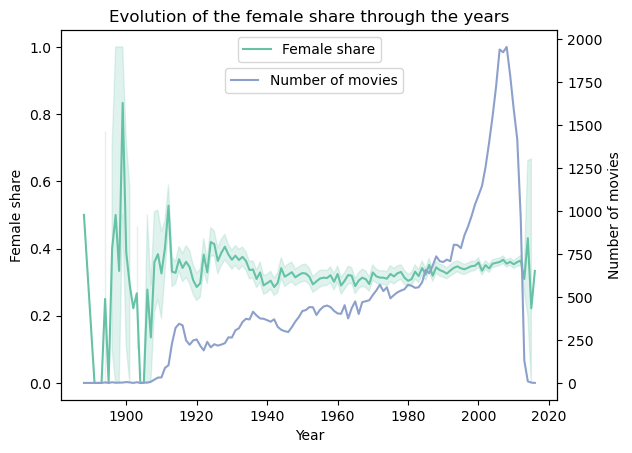

In [97]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.lineplot(data = grouped_gender_movie, x="Movie_year", 
             y="Female_share", ax = ax1, color = '#66c2a5')
ax1.set_ylabel('Female share')
ax2 = ax1.twinx()
sns.lineplot(data = grouped_gender_year, x = 'Movie_year', 
             y = 'Movie_count', color= '#8da0cb', ax = ax2)
ax2.set_ylabel('Number of movies')
ax2.grid(False)
ax1.set(xlabel='Year', ylabel='Female share')
ax2.set(ylabel='Number of movies')
plt.title('Evolution of the female share through the years')
ax1.legend(['Female share'], loc = 'upper center')
ax2.legend(['Number of movies'], loc = [0.33,0.83])

plt.show()


The share of women in movies clearly hasn't evolved significantly. Up until 1920, there are not enough movies to draw any valuable information. The same can be said from 2014. Globally, there as been no significant change throughout the years. Is that result the same for all large movie producing countries?

## Question 1.2: What is the trend in some selected movie-producing countries?

### Look at the largest movie producing countries

In [98]:
#Get all movies with their female share and producing country. Note thate the length of 'grouped_gender_movie_countries'
#is slightly longer than 'grouped_gender_movie' due to unique movies having more than one producing country
grouped_gender_movie_countries = pd.merge(left = grouped_gender_movie, right = movie_countries, 
                                          on = 'Wikipedia_movie_ID', how = 'left')
grouped_gender_movie_countries

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_countries
0,1082508,1888.0,2.0,2.0,0.5,United Kingdom
1,7669437,1894.0,1.0,0.0,1.0,United States of America
2,807258,1896.0,3.0,0.0,1.0,France
3,4062042,1896.0,1.0,1.0,0.5,France
4,436308,1896.0,1.0,1.0,0.5,United States of America
...,...,...,...,...,...,...
71060,32573209,2014.0,0.0,1.0,0.0,NaN
71061,35272184,2014.0,0.0,1.0,0.0,United States of America
71062,35042288,2014.0,0.0,1.0,0.0,India
71063,2312141,2015.0,0.0,4.0,0.0,United States of America


In [99]:
#Get the top movie-producing countries and the total number of movies per country
movies_per_country = grouped_gender_movie_countries.groupby(by = 'Movie_countries')[['Wikipedia_movie_ID']].count()
movies_per_country.rename(columns = {'Wikipedia_movie_ID':'Tot_movie_count'},inplace = True)
movies_per_country.sort_values(by='Tot_movie_count',ascending=False).head()

,Tot_movie_count
Movie_countries,
United States of America,29115
India,7068
United Kingdom,5953
France,3473
Italy,2347


In [100]:
#Merge movies_per_country with grouped_gender_movie_countries, to get a dataset with necessary info for further analysis
grouped_gender_movie_countries = pd.merge(grouped_gender_movie_countries, movies_per_country, left_on = 'Movie_countries',
                right_index = True, how = 'left')
grouped_gender_movie_countries.head(5)

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_countries,Tot_movie_count
0,1082508,1888.0,2.0,2.0,0.5,United Kingdom,5953.0
1,7669437,1894.0,1.0,0.0,1.0,United States of America,29115.0
2,807258,1896.0,3.0,0.0,1.0,France,3473.0
3,4062042,1896.0,1.0,1.0,0.5,France,3473.0
4,436308,1896.0,1.0,1.0,0.5,United States of America,29115.0


In order to visualise the evolution of female_share over time (per country), we perform a linear regression: $female\, share = intercept + movie\, year \cdot slope$, to observe the general trend.

To make the code 'cleaner', we create a function to retrieve results from linear regression

In [101]:
def retrieve_info_from_statsmodels_summary(results_summary):
    '''
    Retrieves R_squared, coefficients and their associated p-values 
    from summary table of linear regression
    
    '''
    
    #Get first (contains r-squared) summary table. 
    #Convert it to html and then pandas dataframe
    results_summary_table0 = results_summary.tables[0].as_html()
    results_summary_table0 = pd.read_html(results_summary_table0)[0]
    r_squared = results_summary_table0.loc[0,3]
    
    #Get second (contains coefficients and associated p-values) summary table. 
    #Convert it to html and then pandas dataframe
    results_summary_table1 = results_summary.tables[1].as_html()
    results_summary_table1 = pd.read_html(results_summary_table1, header=0, index_col=0)[0]
    intercept = results_summary_table1.loc['Intercept','coef']
    intercept_pvalue = results_summary_table1.iloc[0,3]
    slope = results_summary_table1.loc['Movie_year','coef']
    slope_pvalue = results_summary_table1.iloc[1,3]
    
    return [r_squared, intercept, intercept_pvalue, slope, slope_pvalue]

For each country, we select only the years with at least 4 movies produced by country. We perform a regression analysis, and plot the results for only selected countries. We selected the United States of America and India because they produced most of the movies from the dataset. Mexico was selected as it has one of the lowest slope value (negative) whereas Taiwan, one of the highest. These countries where selected based on the dataframe 'LR_countries' created in the loop below. Only countries whose p-values of the slope were significant were kept in the dataframe.

In [102]:
#!pip install lxml

In [103]:
countries_to_plot = ['United States of America', 'India', 'Mexico', 'Taiwan']

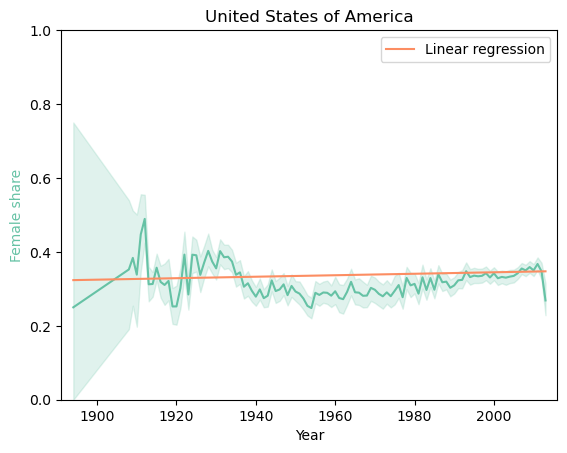

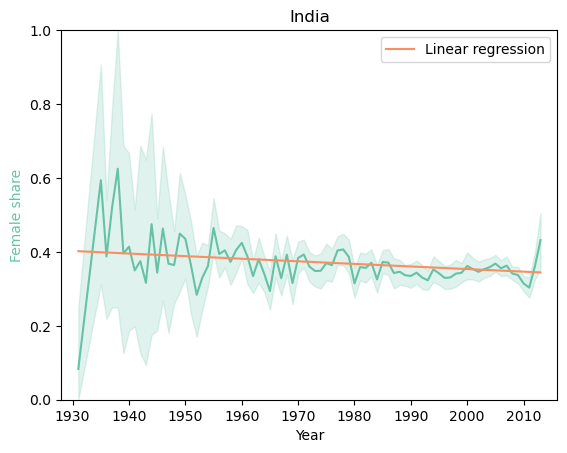

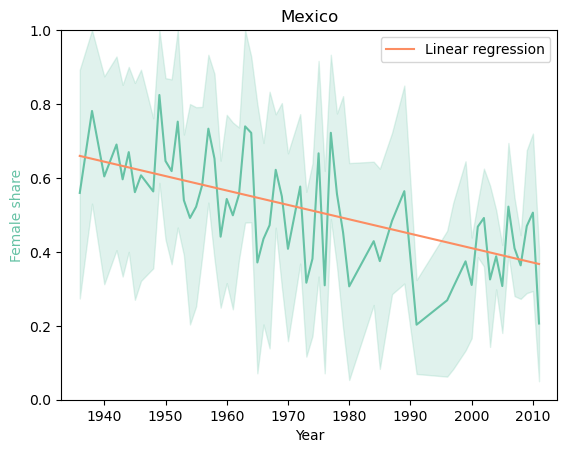

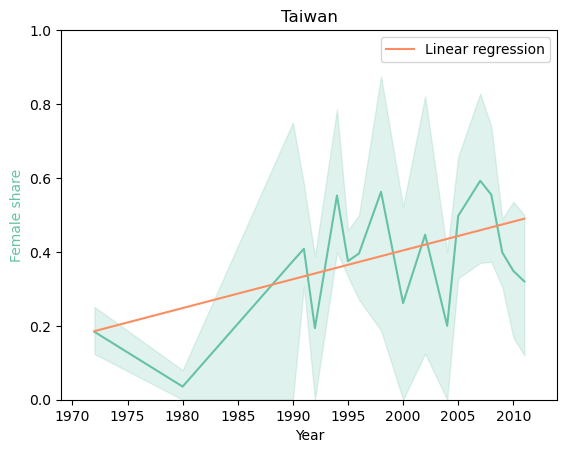

In [104]:
all_countries = movie_countries.Movie_countries.unique()

#Creation of dataframe to store linear regression results
LR_df = pd.DataFrame(columns=['Country', 'R_squared', 'Intercept', 'Intercept_pvalue', 'Slope', 'Slope_pvalue'])

for country in all_countries:
    
    #Retrieve the data of the specific country
    df = grouped_gender_movie_countries[grouped_gender_movie_countries.Movie_countries == country]

    #Get the number of movies per year for specific country
    temp_movie_yearly_count = df.groupby(by = 'Movie_year')[['Wikipedia_movie_ID']].count()
    
    #Get only the years where there are at least 4 movies produced
    years_of_interest = temp_movie_yearly_count[temp_movie_yearly_count.Wikipedia_movie_ID >= 4].index

    #Get the movies that respect condition above
    df = df[df.Movie_year.isin(years_of_interest)]
    
    #df might be empty if the country doesn't meet the above criteria
    if df.empty:
        continue
        
    #Linear regression
    mod = smf.ols(formula = 'Female_share ~ Movie_year', data = df)
    res = mod.fit()
    results = res.summary()

    #Retrieve R_squared, coefficients and associated p-values into a list
    LR_list = retrieve_info_from_statsmodels_summary(results)
    LR_list.insert(0, country)
    
    #Add the linear regression parameters to LR_df
    LR_df.loc[len(LR_df)] = LR_list


    #if plot_yes:
    if country in countries_to_plot:
        
        #Plot the evolution of female share
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        
        #Plot Female share across the years
        sns.lineplot(data = df, x="Movie_year", 
                     y="Female_share", ax = ax1, color = '#66c2a5')
        
        #ax2 = ax1.twinx()
        
        #Plot the number of movie per year
        #sns.lineplot(data = temp_movie_yearly_count, x = temp_movie_yearly_count.index, 
         #            y = 'Wikipedia_movie_ID', color= '#8da0cb', ax = ax2)
        
        
        #Plot linear regression line
        slope = LR_df[LR_df.Country == country]['Slope'].values
        intercept = LR_df[LR_df.Country == country]['Intercept'].values

        x_series = df.Movie_year.sort_values().unique()
        y_series = slope*x_series + intercept
        sns.lineplot(x = x_series, y = y_series, ax = ax1, color = '#fc8d62',label='Linear regression')
        
        #Make nice graph
        ax1.set_ylabel('Female share')
        #ax2.set_ylabel('Number of movies')
        #ax2.grid(False)
        ax1.set(xlabel='Year', ylabel='Female share')
        #ax2.set(ylabel='Number of movies')
        ax1.yaxis.label.set_color('#66c2a5')
        #ax2.yaxis.label.set_color('#8da0cb')
        ax1.set_xlim([min(years_of_interest)-3,max(years_of_interest)+3])
        ax1.set_ylim([0,1])
        plt.legend()
        plt.title(f'{country}')
        plt.show()

In [105]:
#Get countries where p-value of the slope is significant
LR_countries = LR_df[LR_df.Slope_pvalue<0.05].sort_values('Slope')
LR_countries

,Country,R_squared,Intercept,Intercept_pvalue,Slope,Slope_pvalue
62,Bangladesh,0.172,8.064200e+01,0.039,-0.040100,0.039
14,Mexico,0.064,8.210100e+00,0.000,-0.003900,0.000
19,Sweden,0.014,3.170800e+00,0.004,-0.001400,0.011
17,Netherlands,0.012,1.783000e+00,0.008,-0.000700,0.036
12,India,0.004,1.753500e+00,0.000,-0.000700,0.000
69,United Arab Emirates,0.000,4.895000e-08,0.007,0.000098,0.007
67,Kingdom of Great Britain,-0.000,1.235000e-07,0.001,0.000200,0.001
0,United States of America,0.001,-5.520000e-02,0.539,0.000200,0.000
8,German Democratic Republic,0.000,1.262000e-07,0.046,0.000200,0.046
70,Nigeria,0.000,8.235000e-08,0.045,0.000200,0.045


## Question 1.3 - What is the trend for different movie genres?

In [106]:
#Get all movies with their female share and genre. Note thate the length of 'grouped_gender_movie_genres'
#is slightly longer than 'grouped_gender_movie' due to unique movies having more than one genre
grouped_gender_movie_genres = pd.merge(left = grouped_gender_movie, right = movie_genres, 
                                          on = 'Wikipedia_movie_ID', how = 'left')
grouped_gender_movie_genres

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_genres
0,1082508,1888.0,2.0,2.0,0.5,Short Film
1,1082508,1888.0,2.0,2.0,0.5,Silent film
2,1082508,1888.0,2.0,2.0,0.5,Indie
3,1082508,1888.0,2.0,2.0,0.5,Black-and-white
4,7669437,1894.0,1.0,0.0,1.0,Short Film
...,...,...,...,...,...,...
204255,35042288,2014.0,0.0,1.0,0.0,NaN
204256,2312141,2015.0,0.0,4.0,0.0,Crime Fiction
204257,2312141,2015.0,0.0,4.0,0.0,Science Fiction
204258,2312141,2015.0,0.0,4.0,0.0,Action


In [107]:
#Get the total number of movies per genre
movies_per_genre = grouped_gender_movie_genres.groupby(by = 'Movie_genres')[['Wikipedia_movie_ID']].count()
movies_per_genre.rename(columns = {'Wikipedia_movie_ID':'Tot_movie_count'},inplace = True)
movies_per_genre.sort_values(by='Tot_movie_count',ascending=False).head()

,Tot_movie_count
Movie_genres,
Drama,28236
Comedy,14426
Romance Film,9040
Thriller,8029
Action,7776


In [108]:
grouped_gender_movie_genres = pd.merge(grouped_gender_movie_genres, movies_per_genre, left_on = 'Movie_genres',
                right_index = True, how = 'left')
grouped_gender_movie_genres.head()

,Wikipedia_movie_ID,Movie_year,Female,Male,Female_share,Movie_genres,Tot_movie_count
0,1082508,1888.0,2.0,2.0,0.5,Short Film,4452.0
1,1082508,1888.0,2.0,2.0,0.5,Silent film,3987.0
2,1082508,1888.0,2.0,2.0,0.5,Indie,6131.0
3,1082508,1888.0,2.0,2.0,0.5,Black-and-white,7325.0
4,7669437,1894.0,1.0,0.0,1.0,Short Film,4452.0


Similarly to what was done for countries, we select the movies to plot based on number of movies of a genre, lowest slope, and highest slope.

In [109]:
genres_to_plot = ['Drama', 'Comedy', 'Thriller', 'Action', 'Blaxploitation',"Children's Fantasy", "Children's",'Bollywood']

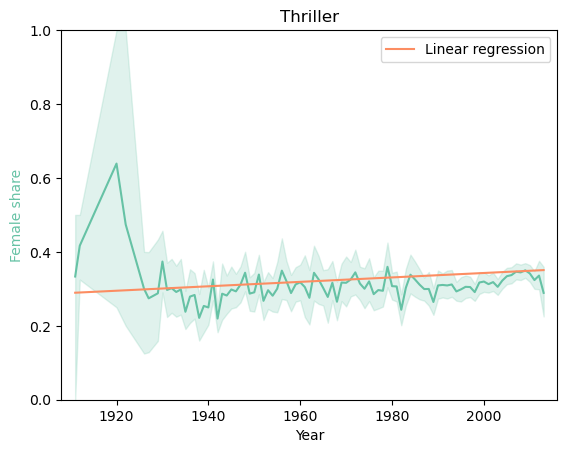

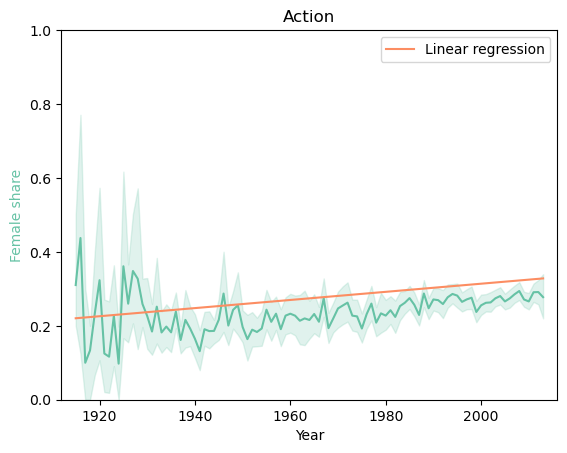

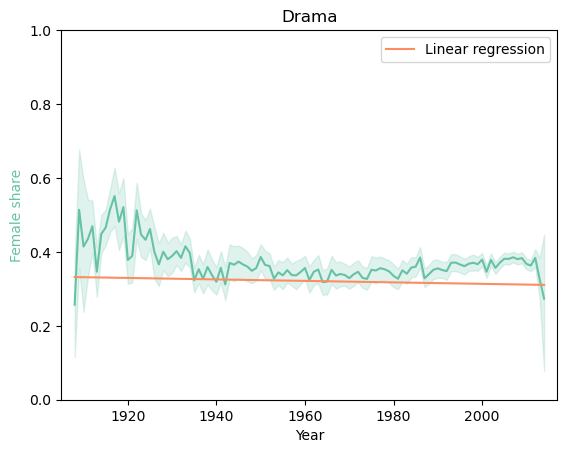

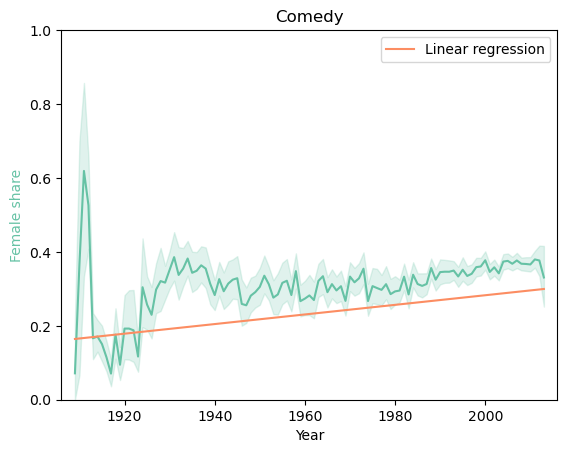

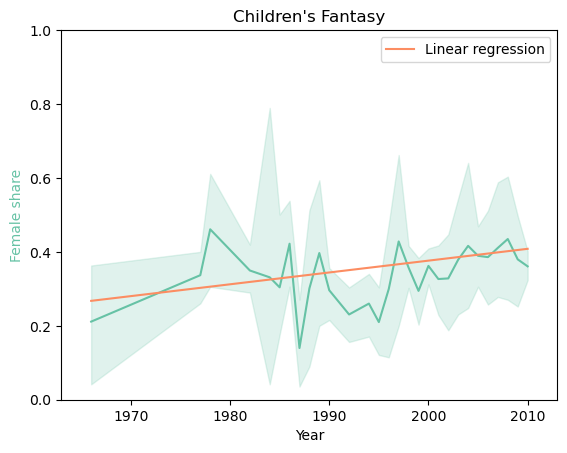

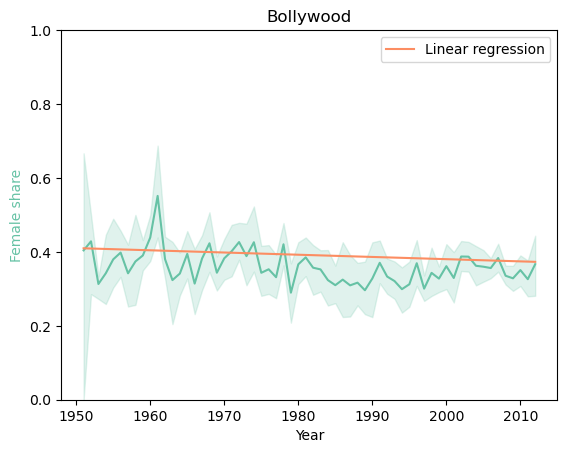

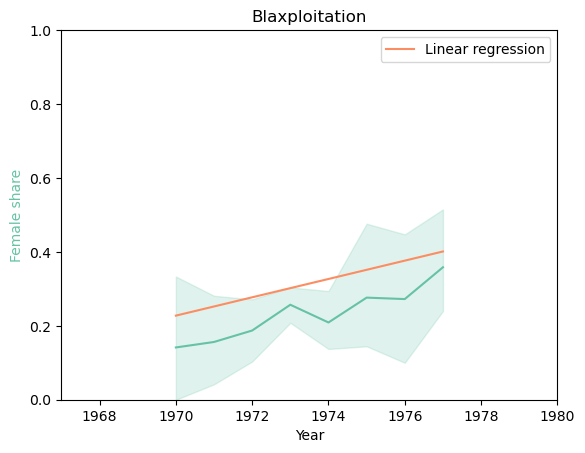

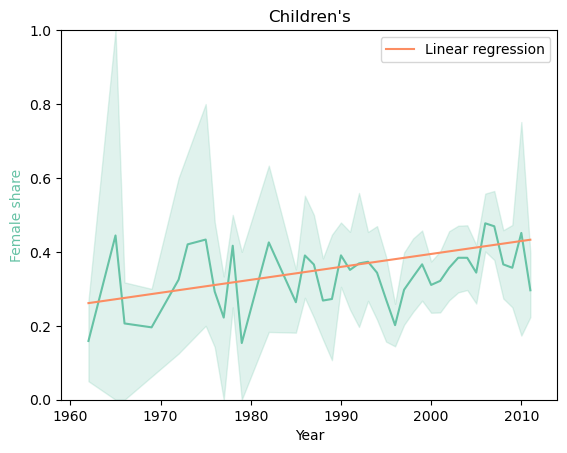

In [110]:
#extreme_FS_countries = [min_FS_country, max_FS_country]
all_genres = movie_genres.Movie_genres.unique()

#Creation of dataframe to store linear regression results
LR_df = pd.DataFrame(columns=['Genre', 'R_squared', 'Intercept', 'Intercept_pvalue', 'Slope', 'Slope_pvalue'])
plot_yes = False

for genre in all_genres:
    
    #Retrieve the data of the specific genre
    df = grouped_gender_movie_genres[grouped_gender_movie_genres.Movie_genres == genre]

    #Get the number of movies per year for specific genre
    temp_movie_yearly_count = df.groupby(by = 'Movie_year')[['Wikipedia_movie_ID']].count()
    
    #Get only the years where there are at least 5 movies produced
    years_of_interest = temp_movie_yearly_count[temp_movie_yearly_count.Wikipedia_movie_ID >= 3].index

    #Get the movies that respect condition above
    df = df[df.Movie_year.isin(years_of_interest)]
    
    #df might be empty if the genre doesn't meet the above criteria
    if df.empty:
        continue
        
    #Linear regression
    mod = smf.ols(formula = 'Female_share ~ Movie_year', data = df)
    res = mod.fit()
    results = res.summary()

    #Retrieve R_squared, coefficients and associated p-values into a list
    LR_list = retrieve_info_from_statsmodels_summary(results)
    LR_list.insert(0, genre)
    
    #Add the linear regression parameters to LR_df
    LR_df.loc[len(LR_df)] = LR_list


    if genre in genres_to_plot:
        
        #Plot the evolution of female share
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        
        #Plot Female share across the years
        sns.lineplot(data = df, x="Movie_year", 
                     y="Female_share", ax = ax1, color = '#66c2a5')
        
        #ax2 = ax1.twinx()
        
        #Plot the number of movie per year
        #sns.lineplot(data = temp_movie_yearly_count, x = temp_movie_yearly_count.index, 
         #            y = 'Wikipedia_movie_ID', color= '#8da0cb', ax = ax2)
        
        
        #Plot linear regression line
        slope = LR_df[LR_df.Genre == genre]['Slope'].values
        intercept = LR_df[LR_df.Genre == genre]['Intercept'].values

        x_series = df.Movie_year.sort_values().unique()
        y_series = slope*x_series + intercept
        sns.lineplot(x = x_series, y = y_series, ax = ax1, color = '#fc8d62',label='Linear regression')
        
        #Make nice graph
        ax1.set_ylabel('Female share')
        #ax2.set_ylabel('Number of movies')
        #ax2.grid(False)
        ax1.set(xlabel='Year', ylabel='Female share')
        #ax2.set(ylabel='Number of movies')
        ax1.yaxis.label.set_color('#66c2a5')
        #ax2.yaxis.label.set_color('#8da0cb')
        ax1.set_xlim([min(years_of_interest)-3,max(years_of_interest)+3])
        ax1.set_ylim([0,1])
        plt.legend()
        plt.title(f'{genre}')
        plt.show()

In [111]:
LR_genres = LR_df[LR_df.Slope_pvalue<0.05].sort_values('Slope')
LR_genres.head(60)

,Genre,R_squared,Intercept,Intercept_pvalue,Slope,Slope_pvalue
230,Hip hop movies,0.093,2.098260e+01,0.024,-0.010400,0.025
9,Crime Drama,0.025,3.000400e+00,0.000,-0.001400,0.000
21,Musical,0.010,1.964900e+00,0.000,-0.000800,0.000
43,Bollywood,0.005,1.580300e+00,0.001,-0.000600,0.014
30,War film,0.003,1.201200e+00,0.001,-0.000500,0.009
8,Drama,0.000,7.135000e-01,0.000,-0.000200,0.001
153,Juvenile Delinquency Film,0.000,3.842000e-08,0.023,0.000074,0.023
241,Road-Horror,0.000,6.607000e-08,0.007,0.000100,0.007
238,Crime,-0.000,5.399000e-08,0.009,0.000100,0.009
237,Heaven-Can-Wait Fantasies,0.000,6.892000e-08,0.002,0.000100,0.002


## Question 1.4 - For similar careers, do actors participate in more movies than actresses?

### Observational study

In [112]:
actors = actor[actor.Gender == 'M']
actress = actor[actor.Gender == 'F']

#Delete all rows with a nan
#actors = actors.dropna()
#actress = actress.dropna()

In [113]:
matching_critera = ["First_movie_year","Min_actor_age", "Max_actor_age", "Career_length", "Ethnicity"]

#Match athletes on 'matching_criteria' and delete duplicates as we do 1-to-1 matching
matching_actors = pd.merge(actors,actress,how='inner',on = matching_critera)

#1-on-1 matching
matching_actors = matching_actors[matching_actors.Actor_name_x.duplicated(keep='first') == False]
matching_actors = matching_actors[matching_actors.Actor_name_y.duplicated(keep='first') == False]


In [114]:
#Rearranging columns to change shape of df
matching_actors['First_movie_year_y'] = matching_actors.loc[:, 'First_movie_year']
matching_actors['Min_actor_age_y'] = matching_actors.loc[:, 'Min_actor_age']
matching_actors['Max_actor_age_y'] = matching_actors.loc[:, 'Max_actor_age']
matching_actors['Career_length_y'] = matching_actors.loc[:, 'Career_length']
matching_actors['Ethnicity_y'] = matching_actors.loc[:, 'Ethnicity']
matching_actors=matching_actors.rename(columns={'First_movie_year':'First_movie_year_x',
                                                  'Min_actor_age':'Min_actor_age_x',
                                                  'Max_actor_age':'Max_actor_age_x',
                                                  'Career_length':'Career_length_x',
                                                  'Ethnicity':'Ethnicity_x'})

matching_actors

,Movie_count_x,First_movie_year_x,Gender_x,Actor_name_x,Min_actor_age_x,Max_actor_age_x,Career_length_x,Ethnicity_x,Movie_count_y,Gender_y,Actor_name_y,First_movie_year_y,Min_actor_age_y,Max_actor_age_y,Career_length_y,Ethnicity_y
0,1,1994.0,M,Jimmy Chamberlin,29.0,29.0,1.0,NaN,1,F,Geno Lechner,1994.0,29.0,29.0,1.0,NaN
21,36,1921.0,M,Warner Baxter,NaN,NaN,NaN,NaN,1,F,Natacha Rambova,1921.0,NaN,NaN,NaN,NaN
14889,56,1920.0,M,Lewis Stone,NaN,NaN,NaN,NaN,2,F,Karla Schramm,1920.0,NaN,NaN,NaN,NaN
28665,2,2001.0,M,Chester Bennington,25.0,34.0,10.0,NaN,11,F,Angelica Lee,2001.0,25.0,34.0,10.0,NaN
28681,1,2001.0,M,Joe Hahn,24.0,24.0,1.0,NaN,1,F,Serena Brooke,2001.0,24.0,24.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11153531,4,1976.0,M,Andy Kaufman,31.0,33.0,3.0,NaN,2,F,Britt Langlie,1976.0,31.0,33.0,3.0,NaN
11153532,1,1982.0,M,Xavier Serbia,13.0,13.0,1.0,NaN,1,F,Katherine Healy,1982.0,13.0,13.0,1.0,NaN
11153534,1,1988.0,M,William Gaines,66.0,66.0,1.0,NaN,1,F,Macide Tanir,1988.0,66.0,66.0,1.0,NaN
11153535,3,2004.0,M,Sean Waltman,31.0,33.0,3.0,NaN,3,F,Lucy Davis,2004.0,31.0,33.0,3.0,NaN


In [115]:
#split mathing actors into a dataset for x and one for y
matching_actors_x = matching_actors[matching_actors.columns[0:int(matching_actors.shape[1]/2)]]
matching_actors_y = matching_actors[matching_actors.columns[int(matching_actors.shape[1]/2):]]

#Sort both lexicographically to get the same column order
matching_actors_x = matching_actors_x.reindex(sorted(matching_actors_x.columns), axis=1)
matching_actors_y = matching_actors_y.reindex(sorted(matching_actors_y.columns), axis=1)

#Remove suffix:
matching_actors_x.columns = matching_actors_x.columns.str.replace("_x", "")
matching_actors_y.columns = matching_actors_y.columns.str.replace("_y", "")

In [116]:
#Concatane both datasets (vertically)
matching_one_actors_row = pd.concat([matching_actors_x,matching_actors_y], ignore_index = True)
matching_one_actors_row 

,Actor_name,Career_length,Ethnicity,First_movie_year,Gender,Max_actor_age,Min_actor_age,Movie_count,First_movieear
0,Jimmy Chamberlin,1.0,NaN,1994.0,M,29.0,29.0,1,NaN
1,Warner Baxter,NaN,NaN,1921.0,M,NaN,NaN,36,NaN
2,Lewis Stone,NaN,NaN,1920.0,M,NaN,NaN,56,NaN
3,Chester Bennington,10.0,NaN,2001.0,M,34.0,25.0,2,NaN
4,Joe Hahn,1.0,NaN,2001.0,M,24.0,24.0,1,NaN
...,...,...,...,...,...,...,...,...,...
9389,Britt Langlie,3.0,NaN,NaN,F,33.0,31.0,2,1976.0
9390,Katherine Healy,1.0,NaN,NaN,F,13.0,13.0,1,1982.0
9391,Macide Tanir,1.0,NaN,NaN,F,66.0,66.0,1,1988.0
9392,Lucy Davis,3.0,NaN,NaN,F,33.0,31.0,3,2004.0


In [117]:
#Apply log on Movie_count as they are heavy-tailed
matching_one_actors_row['log_Movie_count']=matching_one_actors_row.Movie_count.apply(lambda x: np.log(x))
matching_one_actors_row

,Actor_name,Career_length,Ethnicity,First_movie_year,Gender,Max_actor_age,Min_actor_age,Movie_count,First_movieear,log_Movie_count
0,Jimmy Chamberlin,1.0,NaN,1994.0,M,29.0,29.0,1,NaN,0.000000
1,Warner Baxter,NaN,NaN,1921.0,M,NaN,NaN,36,NaN,3.583519
2,Lewis Stone,NaN,NaN,1920.0,M,NaN,NaN,56,NaN,4.025352
3,Chester Bennington,10.0,NaN,2001.0,M,34.0,25.0,2,NaN,0.693147
4,Joe Hahn,1.0,NaN,2001.0,M,24.0,24.0,1,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...
9389,Britt Langlie,3.0,NaN,NaN,F,33.0,31.0,2,1976.0,0.693147
9390,Katherine Healy,1.0,NaN,NaN,F,13.0,13.0,1,1982.0,0.000000
9391,Macide Tanir,1.0,NaN,NaN,F,66.0,66.0,1,1988.0,0.000000
9392,Lucy Davis,3.0,NaN,NaN,F,33.0,31.0,3,2004.0,1.098612


In [118]:
#Creation of list with actors/actresses names that will be used later
observational_study_names = matching_one_actors_row[['Actor_name']]
#Convert array to list
observational_study_names = observational_study_names.values.tolist()
#Unnest nested list
observational_study_names = list(chain.from_iterable(observational_study_names))


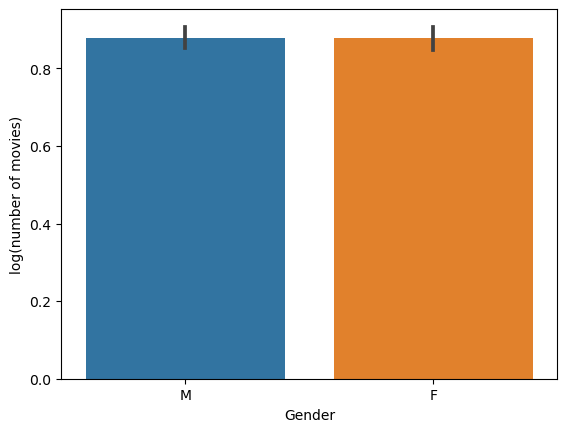

In [119]:
plt.figure()
sns.barplot(data = matching_one_actors_row, x = 'Gender', y = 'log_Movie_count')
plt.ylabel('log(number of movies)')
plt.show()

Let's do a t-test to make sure that there is no statistical difference between the two means

In [122]:
import scipy.stats as stats
print(stats.ttest_ind(matching_one_actors_row[matching_one_actors_row.Gender == 'M']['log_Movie_count'],
                      matching_one_actors_row[matching_one_actors_row.Gender == 'F']['log_Movie_count']))

Ttest_indResult(statistic=0.05001312608335969, pvalue=0.9601129918216447)


The p-value is larger than 0.05, so we cannot reject the null hypothesis that the two samples have identical averages

## Question 1.5: What are the predictors of the share of women and men cast in a movie?

For Q1.5, identify if there are predictors for female share in a given movie, such as movie genre, box office revenue, runtime, country, etc. This will be done using a regression analysis.

As previously seen, the major movie producing country is the United States of America. The regression will hence only be done on US-movies and the 10 genres most represented in movies.

In [123]:
#country of interest
country = 'United States of America'

#Genres of interest
top_movie_genres = number_movie_genres_sorted.index[:10].tolist()
top_movie_genres

['Drama',
 'Comedy',
 'Romance Film',
 'Black-and-white',
 'Action',
 'Thriller',
 'Short Film',
 'World cinema',
 'Crime Fiction',
 'Indie']

In [124]:
#Select only movies made in the USA
regression = df_regression[df_regression.Movie_countries == country]
regression = regression.drop(columns = ['Movie_countries'])

#Select only the top genres
regression = regression[regression.Movie_genres.isin(top_movie_genres)]

#Get dummy variables for movie genres
regression_categorical = pd.get_dummies(regression, columns = ['Movie_genres'])
regression_categorical.head(5)

,Movie_year,Female_share,Movie_boxoffice_revenue,Movie_runtime,Movie_genres_Action,Movie_genres_Black-and-white,Movie_genres_Comedy,Movie_genres_Crime Fiction,Movie_genres_Drama,Movie_genres_Indie,Movie_genres_Romance Film,Movie_genres_Short Film,Movie_genres_Thriller,Movie_genres_World cinema
4,1894.0,1.0,NaN,0.500000,0,0,0,0,0,0,0,1,0,0
6,1894.0,1.0,NaN,0.500000,0,0,0,0,0,1,0,0,0,0
7,1894.0,1.0,NaN,0.500000,0,1,0,0,0,0,0,0,0,0
20,1896.0,0.5,NaN,0.783333,0,0,0,0,0,0,0,1,0,0
21,1896.0,0.5,NaN,0.783333,0,0,0,0,0,0,1,0,0,0


In [125]:
import scipy.stats as stats

#Get z-scores to be able to compare coefficients for predictors with previously incomparable units of measurement
regression_categorical = stats.zscore(regression_categorical, nan_policy = 'omit')

In [126]:
#Rename columns to replace space by underscore
regression_categorical = regression_categorical.rename(columns = {'Movie_genres_Crime Fiction': 'Movie_genres_Crime_Fiction',
                                        'Movie_genres_Black-and-white': 'Movie_genres_Black_and_white',                          
                                        'Movie_genres_Romance Film': 'Movie_genres_Romance_Film',
                                        'Movie_genres_Short Film': 'Movie_genres_Short_Film',
                                        'Movie_genres_World cinema': 'Movie_genres_World_cinema'})


In [127]:
mod_genres = smf.ols(formula = 'Female_share ~ Movie_year + Movie_boxoffice_revenue + Movie_runtime +\
                     Movie_genres_Action + Movie_genres_Black_and_white + Movie_genres_Comedy +\
                     Movie_genres_Crime_Fiction + Movie_genres_Drama + Movie_genres_Indie + \
                     Movie_genres_Romance_Film + Movie_genres_Short_Film +\
                     Movie_genres_Thriller + Movie_genres_World_cinema', data = regression_categorical)
res_genres = mod_genres.fit()
results_genres = res_genres.summary()
print(results_genres)

                            OLS Regression Results                            
Dep. Variable:           Female_share   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     122.1
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          8.11e-291
Time:                        14:20:15   Log-Likelihood:                -13886.
No. Observations:               13490   AIC:                         2.780e+04
Df Residuals:                   13477   BIC:                         2.790e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

R^2 is relatively low (0.098), which means that the variance is not completely explained by our predictors.

In [128]:
# feature names
variables_genres = res_genres.params.index

# quantifying uncertainty!

# coefficients
coefficients_genres = res_genres.params.values

# p-values
p_values_genres = res_genres.pvalues

# standard errors
standard_errors_genres = res_genres.bse.values

#confidence intervals
res_genres.conf_int()


,0,1
Intercept,-0.014846,0.045864
Movie_year,0.085544,0.128668
Movie_boxoffice_revenue,-0.040358,-0.015849
Movie_runtime,-0.155328,-0.101141
Movie_genres_Action,-0.115514,-0.092734
Movie_genres_Black_and_white,0.040184,0.085888
Movie_genres_Comedy,0.021507,0.047878
Movie_genres_Crime_Fiction,-0.075781,-0.052705
Movie_genres_Drama,0.016638,0.045020
Movie_genres_Indie,0.019961,0.048974


In [129]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_genres[1:], variables_genres[1:], standard_errors_genres[1:], p_values_genres[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

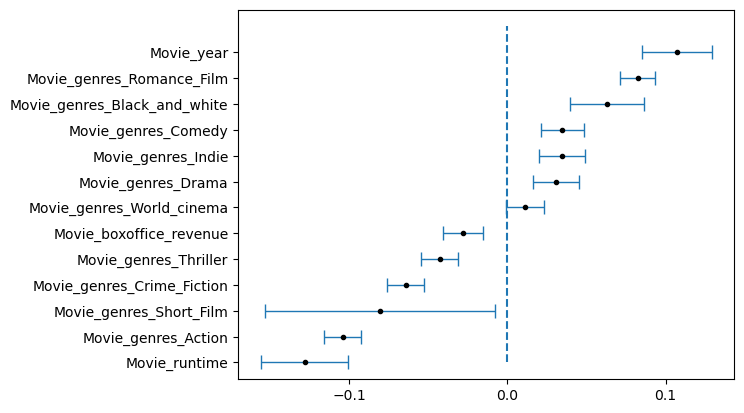

In [130]:
#fancy plotting

from matplotlib.pyplot import figure

#figure(figsize=(25, 22), dpi=80)

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
#Linear regression
#mod = smf.ols(formula = 'Female_share ~ Movie_year + Movie_genres + Movie_countries + \#
  #                      Movie_boxoffice_revenue + Movie_runtime', data = df_regression)
    
mod_genres = smf.ols(formula = 'Female_share ~ Movie_genres', data = df_regression)
res_genres = mod_genres.fit()
results_genres = res_genres.summary()


In [ ]:
print(results_genres)

In [ ]:
# feature names
variables_genres = res_genres.params.index

# quantifying uncertainty!

# coefficients
coefficients_genres = res_genres.params.values

# p-values
p_values_genres = res_genres.pvalues

# standard errors
standard_errors_genres = res_genres.bse.values

#confidence intervals
res_genres.conf_int()

In [ ]:
len(res_genres.conf_int())

In [ ]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_genres[1:], variables_genres[1:], standard_errors_genres[1:], p_values_genres[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

In [ ]:
l1_genres = l1[:25]+l1[len(l1)-15:]
l2_genres = l2[:25]+l2[len(l2)-15:]
l3_genres = l3[:25]+l3[len(l3)-15:]
l4_genres = l4[:25]+l4[len(l4)-15:]

In [ ]:
#fancy plotting

from matplotlib.pyplot import figure

#figure(figsize=(25, 22), dpi=80)

plt.errorbar(l1_genres, np.array(range(len(l1_genres))), xerr= 2*np.array(l3_genres), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1_genres), linestyle = '--')

plt.yticks(range(len(l2_genres)),l2_genres);

BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Interpretation:
- Movie genres 'Bruceploitation' is a sigificant negative predictor of female_share.

Now for countries:

In [ ]:
mod_countries = smf.ols(formula = 'Female_share ~ Movie_countries', data = df_regression)
res_countries = mod_countries.fit()
results_countries = res_countries.summary()
print(results_countries)

In [ ]:
# feature names
variables_countries = res_countries.params.index

# quantifying uncertainty!

# coefficients
coefficients_countries = res_countries.params.values

# p-values
p_values_countries = res_countries.pvalues

# standard errors
standard_errors_countries = res_countries.bse.values

#confidence intervals
res_countries.conf_int()

In [ ]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_countries[1:], variables_countries[1:], standard_errors_countries[1:], p_values_countries[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

In [ ]:
l1_countries = l1[:25]+l1[len(l1)-15:]
l2_countries = l2[:25]+l2[len(l2)-15:]
l3_countries = l3[:25]+l3[len(l3)-15:]
l4_countries = l4[:25]+l4[len(l4)-15:]

In [ ]:
l2_countries

In [ ]:
#fancy plotting

#figure(figsize=(25, 22), dpi=80)

plt.errorbar(l1_countries, np.array(range(len(l1_countries))), xerr= 2*np.array(l3_countries), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1_countries), linestyle = '--')

plt.yticks(range(len(l2_countries)),l2_countries);

BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Looking at boxoffice revenue and movie runtime

In [ ]:
#Linear regression
mod = smf.ols(formula = 'Female_share ~ Movie_boxoffice_revenue + Movie_runtime', data = df_regression)
#mod = smf.ols(formula = 'Female_share ~ Movie_genres', data = df_regression)
res = mod.fit()
results = res.summary()


In [ ]:
print(results)

In [ ]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()

In [ ]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

In [ ]:
#fancy plotting

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

Movie runtime and box_office_revenue are not significant to determine the female_share

# Part 2 - Stereotypes and representation of different genders in the film industry

## Question 2.1

We now want to create a wordcloud showing the most used words for the tv tropes describing female characters as well as for male characters. To do so, the tropes need to be seperated by words.

In [40]:
from PIL import Image

In [86]:
icon_man = np.array(Image.open("../icon_man1.png"))
icon_woman = np.array(Image.open("../icon_woman1.png"))

In [87]:
icon_woman

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [88]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [89]:
# Transform your mask into a new one that will work with the function:
transformed_icon_man = np.ndarray((icon_man.shape[0],icon_man.shape[1]), np.int32)

for i in range(len(icon_man)):
    transformed_icon_man[i] = list(map(transform_format, icon_man[i]))

In [90]:
# Transform your mask into a new one that will work with the function:
transformed_icon_woman = np.ndarray((icon_woman.shape[0],icon_woman.shape[1]), np.int32)

for i in range(len(icon_woman)):
    transformed_icon_woman[i] = list(map(transform_format, icon_woman[i]))

In [91]:
words_F = ' '.join(df_tvtropes_F['character_type'].values)
words_F = words_F.replace("_"," ")

words_M = ' '.join(df_tvtropes_M['character_type'].values)
words_M = words_M.replace("_"," ")

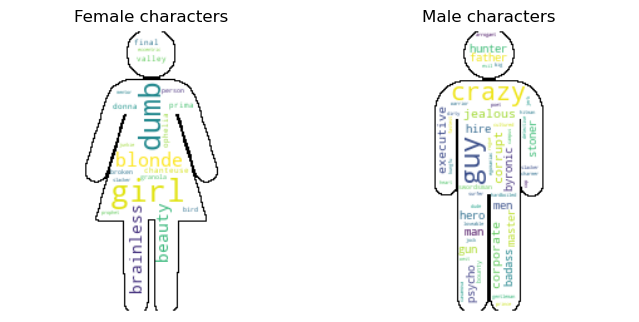

In [108]:


# Generate a word cloud image
wordcloud_F = WordCloud(collocations=False, background_color='white',
                        mask=transformed_icon_woman, contour_width=1,
                        contour_color='black').generate(words_F)
wordcloud_M = WordCloud(collocations=False, background_color='white',
                        mask=transformed_icon_man, contour_width=1,
                        contour_color='black').generate(words_M)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (8,4))

ax1.imshow(wordcloud_F, interpolation="bilinear")
ax1.set_title('Female characters')
ax1.axis("off")
ax2.imshow(wordcloud_M, interpolation="bilinear")
ax2.set_title('Male characters');
ax2.axis("off");
#plt.savefig("../tvtropes_wordcloud.png")
#plt.show()

The most used words characterizing a female and a male character respectively depict pretty much the stereotypes: The beautiful, blonde and dumb girl whereas male characters are represented as corrupt, hero, badass, among other. Moreover, the most used noun for women is "girl", whereas "guy" is mostely used to represent a man.

In addition, we would like to compare these words. Therefore, we make use of the Python library "Empath" in order to categorize every word from the tv tropes into same lexical fields. Empath has predefined classes and directly assign our words to the suitable class. This allows us to directly compare the words of the two gender groups.

Use Empath to categorize words from above into lexical fields.

In [33]:
from empath import Empath
lexicon = Empath()

In [34]:
# Every word of a tv trope is considered seperately
df_category = []
df_category.append(lexicon.analyze('_'.join(df_tvtropes_F['character_type'].values).split('_'),
                                   normalize=True))
df_category.append(lexicon.analyze('_'.join(df_tvtropes_M['character_type'].values).split('_'),
                                   normalize=True))

# transform into a dataframe
df_category = pd.DataFrame(df_category, index = ['Female','Male'])  
df_category

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Female,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.008197,...,0.000000,0.098361,0.000000,0.000000,0.0,0.0,0.0,0.049180,0.0,0.0
Male,0.0,0.0,0.0,0.003018,0.012072,0.0,0.0,0.0,0.0,0.033199,...,0.013078,0.028169,0.035211,0.009054,0.0,0.0,0.0,0.007042,0.0,0.0


In [35]:
# delete lexical field with 0 for both F and M
df_category = df_category.loc[:, (df_category != 0).any(axis=0)]

In [36]:
df_category = df_category.copy().T
df_category

,Female,Male
money,0.000000,0.003018
wedding,0.000000,0.012072
hate,0.008197,0.033199
occupation,0.000000,0.064386
envy,0.000000,0.025151
...,...,...
weapon,0.000000,0.013078
children,0.098361,0.028169
monster,0.000000,0.035211
ocean,0.000000,0.009054


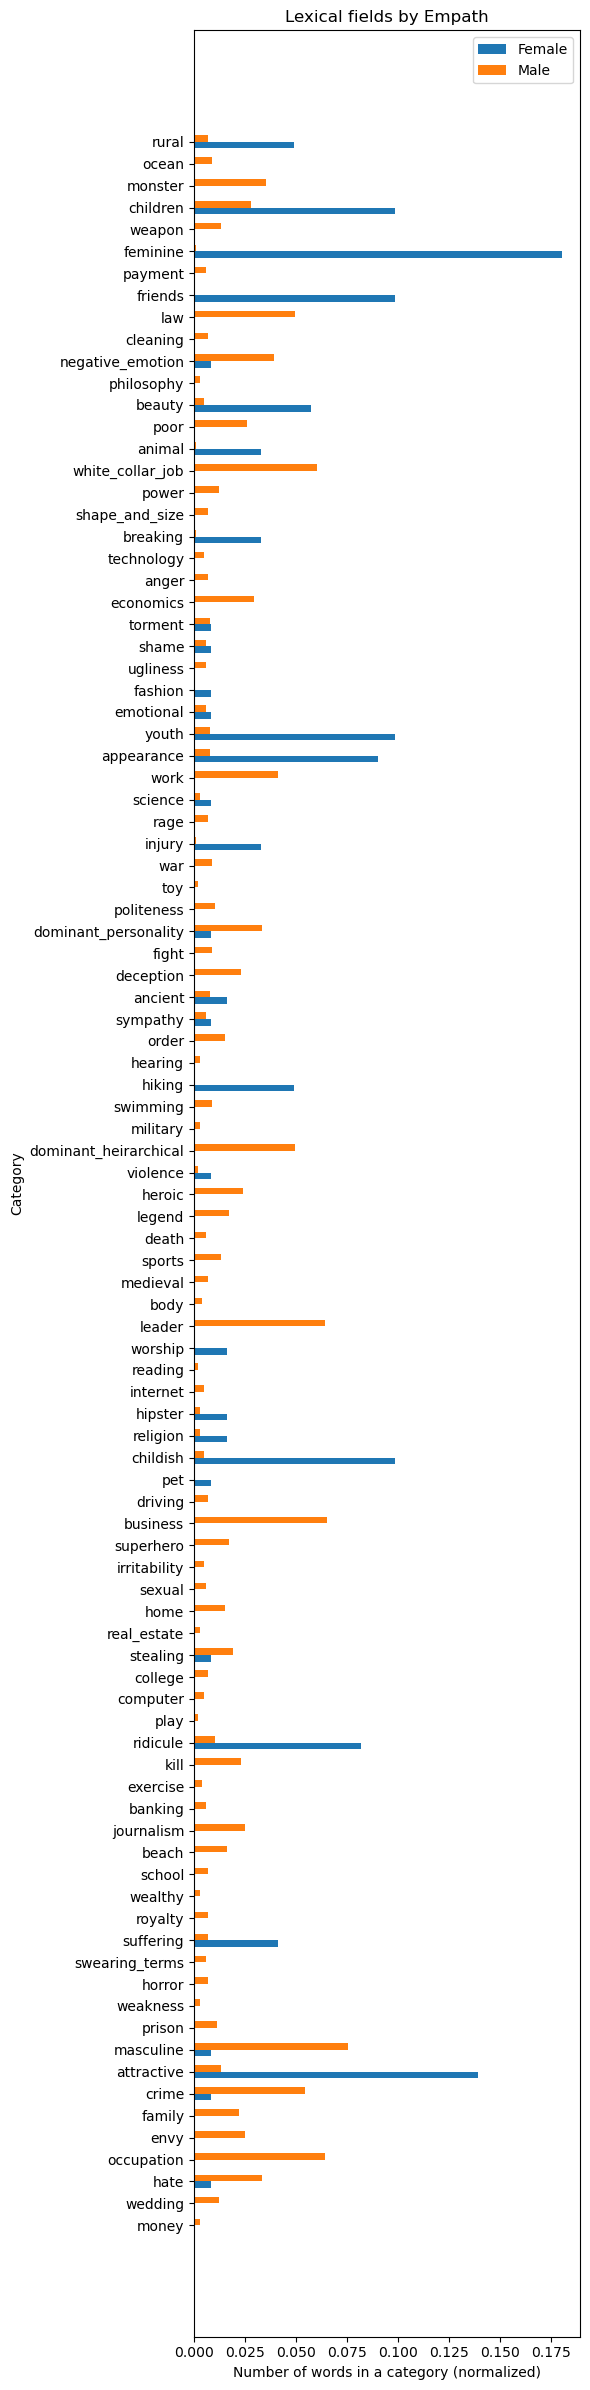

In [37]:
x = np.arange(df_category.shape[0])  # the label locations
new_x = [5*i for i in x]
new_x = np.asanyarray(new_x)
width = 1.5  # the width of the bars

fig, ax = plt.subplots(figsize=(6,24))
rects1 = ax.barh(new_x - width/2, df_category['Female'], width, align='center', label='Female')
rects2 = ax.barh(new_x + width/2, df_category['Male'], width, align='center', label='Male')
ax.set_ylabel('Category')
ax.set_xlabel('Number of words in a category (normalized)')
ax.set_title('Lexical fields by Empath')
ax.set_yticks(new_x, df_category.index)
ax.legend()
fig.tight_layout()

In [38]:
df_category.corr()

,Female,Male
Female,1.000000,-0.157649
Male,-0.157649,1.000000


Pearsons correlation coefficient of lexic fields of female and male character words is -0.158

## Question 2.2 & 2.3
For the second and third subquestion of this second part, we will repeat the procedure applied for Q2.1, but this time we will make use of the newly created dataframe 7, where we extracted all the words associated with a character in a movie. In addition for Q2.3, the words for every gender is divided into three to four time periods depending on the release of the movie. This allows us to observe the change in lexical fields over time for both female and male characters. In this part, we will go a step further and make a principle compnent analysis (PCA) with the classes created by Empath. By visualizing our different groups (male/female + different periods) we expect to find a separation between the words of male and female characters. Furthermore, our expectation is to see more variation of the lexical field of female characters between different periods than for male characters.

First of all, a function is defined which facilitates the creation of a list with words associated to a character. This list is then used for the worldcloud formation and the PCA. In fact, this function cleans all the words in one column of the newly created dataframe 7 to get rid of all noisy characters, and put the words together in one list.

In [109]:
def list_of_words(df,tag):
    '''
    takes as input a dataframe and the tag
    the function extract all the words from the column of the corresponding tag in the df.
    The words are cleaned (remove signs like []).
    Output: a proper list with all the words belonging to the tag in the df
    '''
    # First, we join all words of a selected column (JJ = adjective in this case), separating them 
    # by a blank space. Then, we remove all unwanted signs like []. All white space and commas are
    # replaced by _, so that we can afterwards split at every _ and thus get every single word separately.
    words_all = ' '.join(df[f'{tag}'].astype(str))
    words_all = words_all.replace("'","")
    words_all = words_all.replace("[","")
    words_all = words_all.replace("]","")
    words_all = words_all.replace(" ","_")
    words_all = words_all.replace(",","_")
    
    words_all = words_all.split('_')
    words_all = list(filter(None, words_all))
    words_all = list(map(lambda x: x.lower(), words_all)) # convert all adj to lower case words
#    print(f'Number of {tag} for: {len(words_all)}')
    return words_all

The newly created dataframe number 7 is splitted into 3 parts. The following steps are performed in order to preprocess the dataframe:
- Read every part
- Only keep the character which are associated to a clear gender
- change all letters to lower case
- Merge all three parts into one dataframe
- Add the release year of the movie by merging with the movie_md

In [110]:
# load first part of the summary dataframe
summary_part1 = pd.read_pickle("all_summary_part1.pkl")
summary_part1 = summary_part1.reset_index(drop=True)
# drop rows with undefined Gender
summary_part1_clean = summary_part1[(~summary_part1.Gender.astype(str).str.contains('None'))
                                    & (~summary_part1['Gender'].isnull())].reset_index(drop=True)
# define column 'Gender' as type string
summary_part1_clean['Gender'] = summary_part1_clean['Gender'].astype(str)
# remove square brackets in 'Gender' column
summary_part1_clean['Gender'] = summary_part1_clean['Gender'].map(lambda x: x.lstrip('[[').rstrip(']]'))

In [111]:
# repeat same procedure for part 2
summary_part2 = pd.read_pickle("all_summary_part2.pkl")
summary_part2 = summary_part2.reset_index(drop=True)
# drop rows with undefined Gender
summary_part2_clean = summary_part2[(~summary_part2.Gender.astype(str).str.contains('None'))
                                    & (~summary_part2['Gender'].isnull())].reset_index(drop=True)
# define column 'Gender' as type string
summary_part2_clean['Gender'] = summary_part2_clean['Gender'].astype(str)
# remove square brackets in 'Gender' column
summary_part2_clean['Gender'] = summary_part2_clean['Gender'].map(lambda x: x.lstrip('[[').rstrip(']]'))

In [112]:
# repeat same procedure for part 3
summary_part3 = pd.read_pickle("all_summary_part3.pkl")
summary_part3 = summary_part3.reset_index(drop=True)
# drop rows with undefined Gender
summary_part3_clean = summary_part3[(~summary_part3.Gender.astype(str).str.contains('None'))
                                    & (~summary_part3['Gender'].isnull())].reset_index(drop=True)
# define column 'Gender' as type string
summary_part3_clean['Gender'] = summary_part3_clean['Gender'].astype(str)
# remove square brackets in 'Gender' column
summary_part3_clean['Gender'] = summary_part3_clean['Gender'].map(lambda x: x.lstrip('[[').rstrip(']]'))

In [113]:
# Merge all three parts into one dataframe
summary_all_clean = summary_part1_clean.append(summary_part2_clean, ignore_index=True).\
                        append(summary_part3_clean, ignore_index=True)
summary_all_clean['film_id'] = summary_all_clean['film_id'].astype(int)

In [114]:
# create column with release year in the movie_md
movie_md['release_year'] = movie_md['Movie_release_date'].dt.year

In [115]:
# add release year to the dataframe by merging with movie_md on wikipedia movie ID
summary_all_clean = pd.merge(summary_all_clean, movie_md[['Wikipedia_movie_ID', 'release_year']],
                             left_on='film_id', right_on='Wikipedia_movie_ID', how='left')
summary_all_clean.sample(3)

,film_id,Characters,Lemma,JJ,NN,NNP,NNS,PRP,PRP$,VB,VBG,VBP,VBZ,governor_words,dependent_words,Gender,Wikipedia_movie_ID,release_year
16297,18070237,[John Fletcher],"[she, choose, unambitious, , , wealthy, p...","[unambitious, wealthy, troubled]","[playboy, shipping, line]","[John, Fletcher]",[],[She],[],[],[],[],"[chooses, owns]",NaN,NaN,'M',18070237,1933.0
57095,639796,[Bucho],"[meanwhile, , , the, bartender, alert, Bu...","[black, entire, illegal, next, ]","[bartender, man, security, control, town, ...","[Bucho, Bucho, Bucho, Carolina, El, Maria...","[, activities, men, men]","[him, He, them, them, her]","[his, his, , his]","[, hide, kill, kill]","[looking, paying, , killing]","[, , are, ]","[alerts, is, increases, finds, holds, , ...","[named, look, alerts, increases, employees...",NaN,'M',639796,1995.0
1513,10603679,[Kao Yao],"[along, the, way, Chi, 's, team, encount...",[former],"[way, team, encounter, chief, Gang, gang]","[Chi, Kao, Yao, Masked]",[],[he],[],[],[],[],[],NaN,NaN,'M',10603679,1981.0


We want to separate the previously cleaned dataframe into one df only containing female characters, and one with only male characters.

In [116]:
# create separate dfs by gender
# for the df for men: only keep those rows that contain at least one M, and no F
# Sometimes there are several characters in one line. For this analysis we only want to keep
# the row if all the characters are men, so that we don't include words attributes to a woman
summary_all_clean_M = summary_all_clean[(summary_all_clean.Gender.str.contains('M')) &
                                           (~summary_all_clean.Gender.str.contains('F'))] 
# Vice verso for the women df
summary_all_clean_F = summary_all_clean[(summary_all_clean.Gender.str.contains('F')) &
                                           (~summary_all_clean.Gender.str.contains('M'))]

print(f'Number of female characters in summary_all: {summary_all_clean_F.shape[0]}')
print(f'Number of male characters in summary_all: {summary_all_clean_M.shape[0]}')

Number of female characters in summary_all: 18453
Number of male characters in summary_all: 34105


### Analysis of adjectives (JJ):

We first need to create a list with all adjectives describing female and male characters respectively. This is done by using the previously defined function list_of_words(). In order to create a wordcloud, we need to transform this list in a single string, separated by blank space.

In [117]:
# create a list of adjectives associated to male and female characters respectively
JJ_F_all_list = list_of_words(summary_all_clean_F,'JJ')
# join all words in one string (separated by a blank space) -> needed for wordcloud
JJ_F_all_str = ' '.join(JJ_F_all_list)

# same for M
JJ_M_all_list = list_of_words(summary_all_clean_M,'JJ')
# join all words in one string (separated by a blank space) -> needed for wordcloud
JJ_M_all_str = ' '.join(JJ_M_all_list)

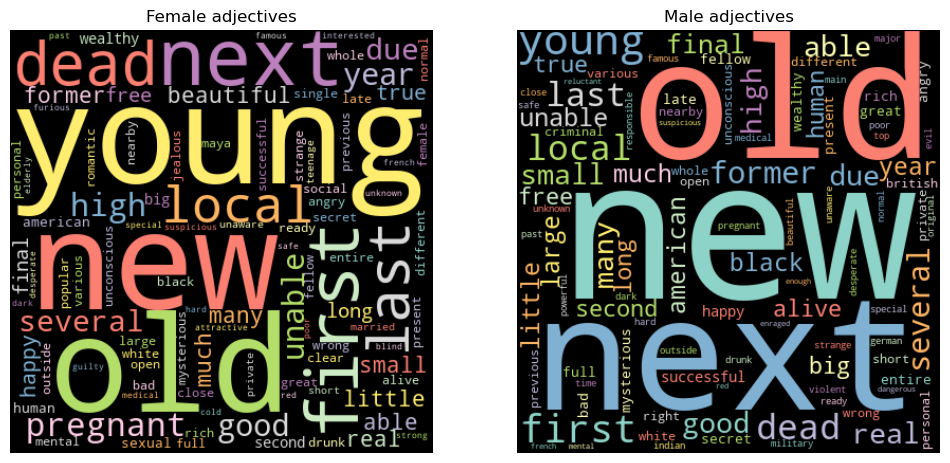

In [118]:
# create and show wordcloud
wordcloud_JJ_F = WordCloud(collocations=False, background_color='black', colormap='Set3',
                          max_words=100, height=400).generate(JJ_F_all_str)
wordcloud_JJ_M = WordCloud(collocations=False, background_color='black', colormap='Set3',
                          max_words=100, height=400).generate(JJ_M_all_str)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (12,6))
ax1.imshow(wordcloud_JJ_F, interpolation="bilinear")
ax1.set_title('Female adjectives')
ax1.axis("off")
ax2.imshow(wordcloud_JJ_M, interpolation="bilinear")
ax2.set_title('Male adjectives');
ax2.axis("off");

In [119]:
# just to check workcloud: create dataframe with adjectives, group them and count number of
# occurances. Sort them in descending order to see the most prevalent adjectives per gender.
# Compare them with the wordcloud.
df_JJ_M_all = pd.DataFrame(JJ_M_all_list, columns = ['adj_M'])
df_JJ_M_all = pd.DataFrame(df_JJ_M_all.groupby('adj_M')['adj_M'].count())
df_JJ_M_all['adj_M'].sort_values(ascending=False).head(10)

adj_M
other    1817
new      1414
own      1324
next     1292
young    1247
old      1082
first    1039
local     819
dead      812
last      766
Name: adj_M, dtype: int64

Overall, the check corresponds to the wordcloud. Only the word 'other' does not appear in the cloud. This is due to the fact that 'other' is considered as a stopword and thus removed when generating the wordcloud due to their default built-in stopword list. That is why new appears as the most used word in the wordcloud above. We can therefore trust the wordcloud!

The next step is to categorize these adjectives into classes so that we can compare female and male adjectives. This is done by using Empath, which has a predefined set of classes to which our adjectives are attributed. The results are shown in the graph below.

In [120]:
lexicon = Empath()
df_category_JJ = []
df_category_JJ.append(lexicon.analyze(JJ_F_all_list, normalize=True))
df_category_JJ.append(lexicon.analyze(JJ_M_all_list, normalize=True))

# transform into a dataframe
df_category_JJ = pd.DataFrame(df_category_JJ, index = ['Female','Male'])

# delete lexical field with 0 for both F and M
df_category_JJ = df_category_JJ.loc[:, (df_category_JJ != 0).any(axis=0)]

df_category_JJ = df_category_JJ.copy().T

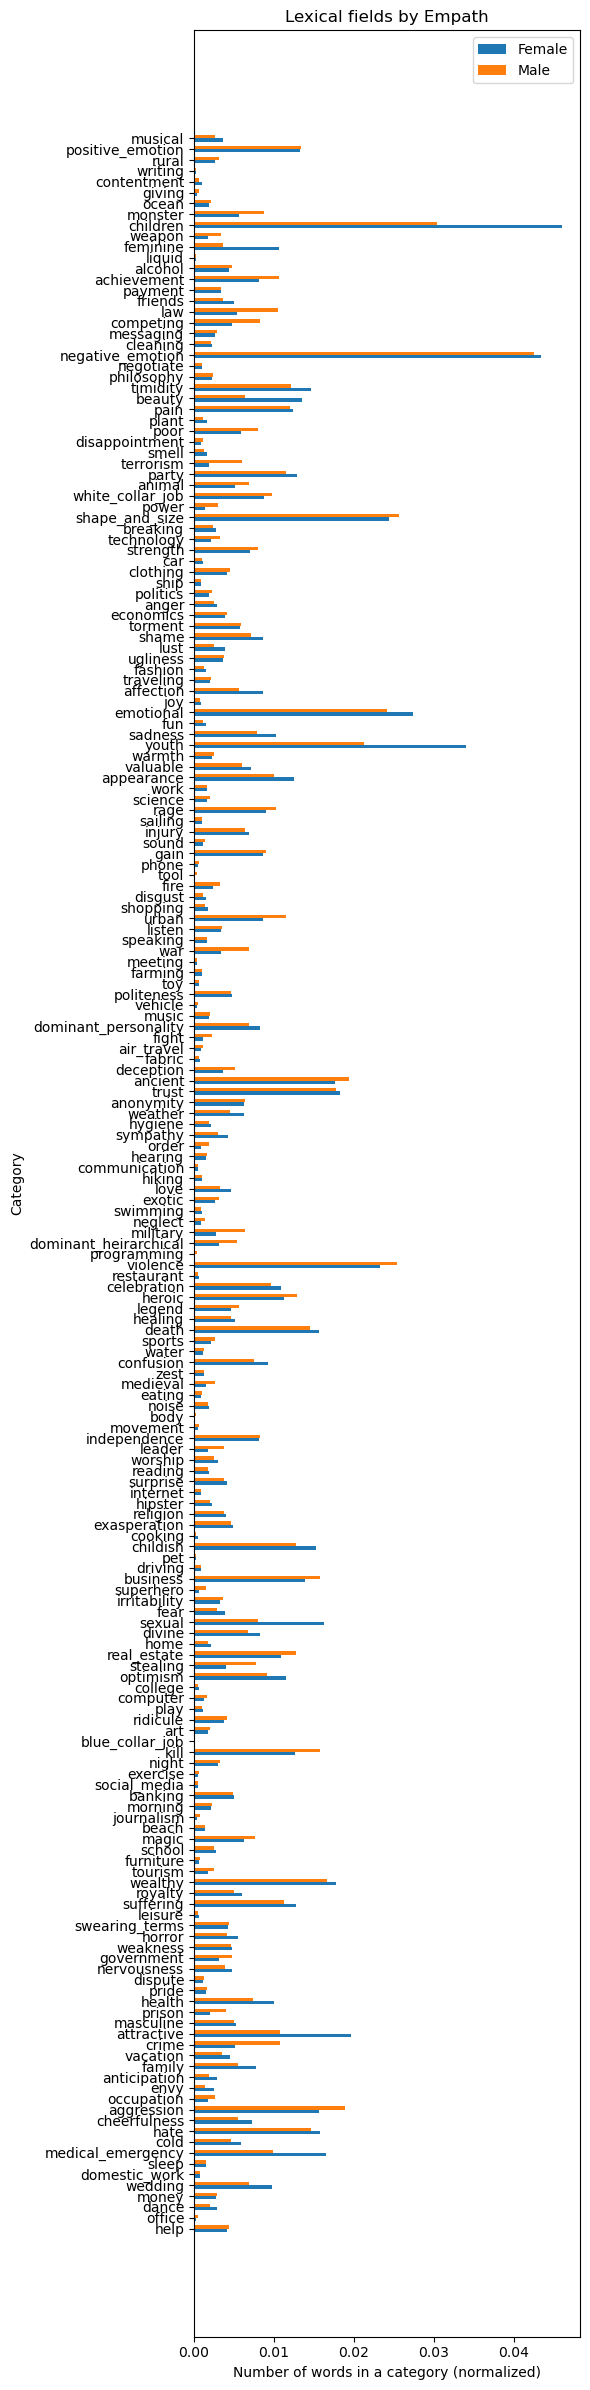

In [121]:
x = np.arange(df_category_JJ.shape[0])  # the label locations
new_x = [10*i for i in x]
new_x = np.asanyarray(new_x)
width = 3  # the width of the bars

fig, ax = plt.subplots(figsize=(6,24))
rects1 = ax.barh(new_x - width/2, df_category_JJ['Female'], width, align='center', label='Female')
rects2 = ax.barh(new_x + width/2, df_category_JJ['Male'], width, align='center', label='Male')
ax.set_ylabel('Category')
ax.set_xlabel('Number of words in a category (normalized)')
ax.set_title('Lexical fields by Empath')
ax.set_yticks(new_x, df_category_JJ.index)
ax.legend()
fig.tight_layout()

This graph is not very pretty because there are too many categories. As we are interested in the categories where there are big differences between male and female, we therefore extract the categories with a difference between the gender of more than a defined threshold. The results are depicted in a graph.

In [122]:
# only keep the once with a significant difference between men and women
df_cat_JJ_difference = df_category_JJ[abs(df_category_JJ['Female']-df_category_JJ['Male']) > 0.005]
df_cat_JJ_difference =df_cat_JJ_difference.reset_index()
cat_list_JJ = df_cat_JJ_difference['index'].to_list()

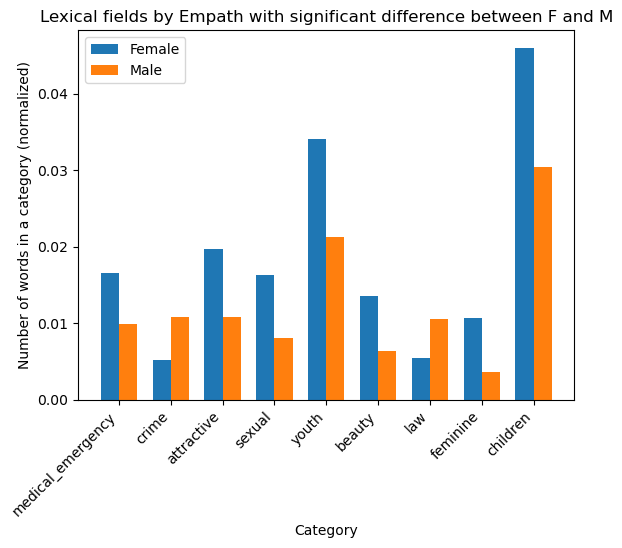

In [123]:
index = np.arange(df_cat_JJ_difference.shape[0])
bar_width = 0.35

fig, ax = plt.subplots()
female = ax.bar(index, df_cat_JJ_difference['Female'], bar_width,
                label="Female")

male = ax.bar(index+bar_width, df_cat_JJ_difference['Male'],
                 bar_width, label="Male")

ax.set_xlabel('Category')
ax.set_ylabel('Number of words in a category (normalized)')
ax.set_title('Lexical fields by Empath with significant difference between F and M')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_cat_JJ_difference['index'], rotation=45, ha='right')
ax.legend()

plt.show()

### Analysis of nouns (NN):

Repeat the same procedure with NN instead of JJ

In [124]:
# create a list of nouns associated to male and female characters respectively
NN_F_all_list = list_of_words(summary_all_clean_F,'NN')
# join all words in one string (separated by a blank space) -> needed for wordcloud
NN_F_all_str = ' '.join(NN_F_all_list)

# same for M
NN_M_all_list = list_of_words(summary_all_clean_M,'NN')
# join all words in one string (separated by a blank space) -> needed for wordcloud
NN_M_all_str = ' '.join(NN_M_all_list)

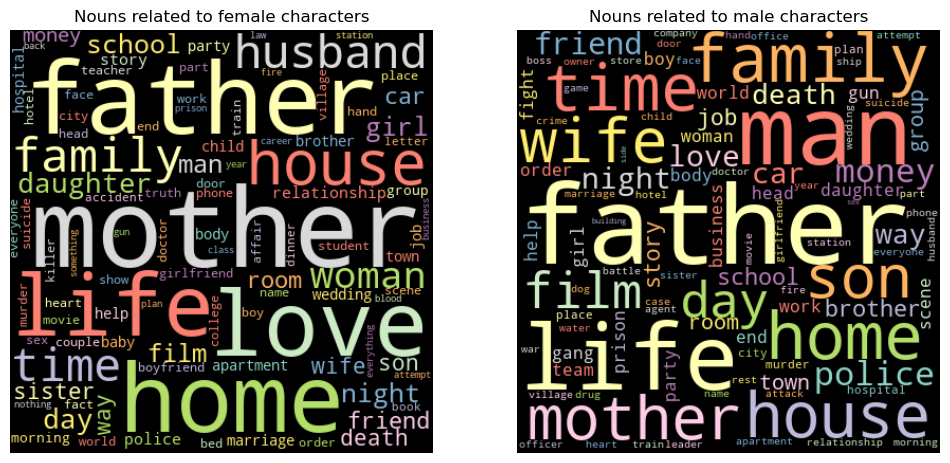

In [125]:
wordcloud_NN_F = WordCloud(collocations=False, background_color='black', colormap='Set3',
                          max_words=100, height=400).generate(NN_F_all_str)
wordcloud_NN_M = WordCloud(collocations=False, background_color='black', colormap='Set3',
                          max_words=100, height=400).generate(NN_M_all_str)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (12,6))
ax1.imshow(wordcloud_NN_F, interpolation="bilinear")
ax1.set_title('Nouns related to female characters')
ax1.axis("off")
ax2.imshow(wordcloud_NN_M, interpolation="bilinear")
ax2.set_title('Nouns related to male characters');
ax2.axis("off");

In [126]:
lexicon = Empath()
df_category_NN = []
df_category_NN.append(lexicon.analyze(NN_F_all_list, normalize=True))
df_category_NN.append(lexicon.analyze(NN_M_all_list, normalize=True))

# transform into a dataframe
df_category_NN = pd.DataFrame(df_category_NN, index = ['Female','Male'])

# delete lexical field with 0 for both F and M
df_category_NN = df_category_NN.loc[:, (df_category_NN != 0).any(axis=0)]

df_category_NN = df_category_NN.copy().T

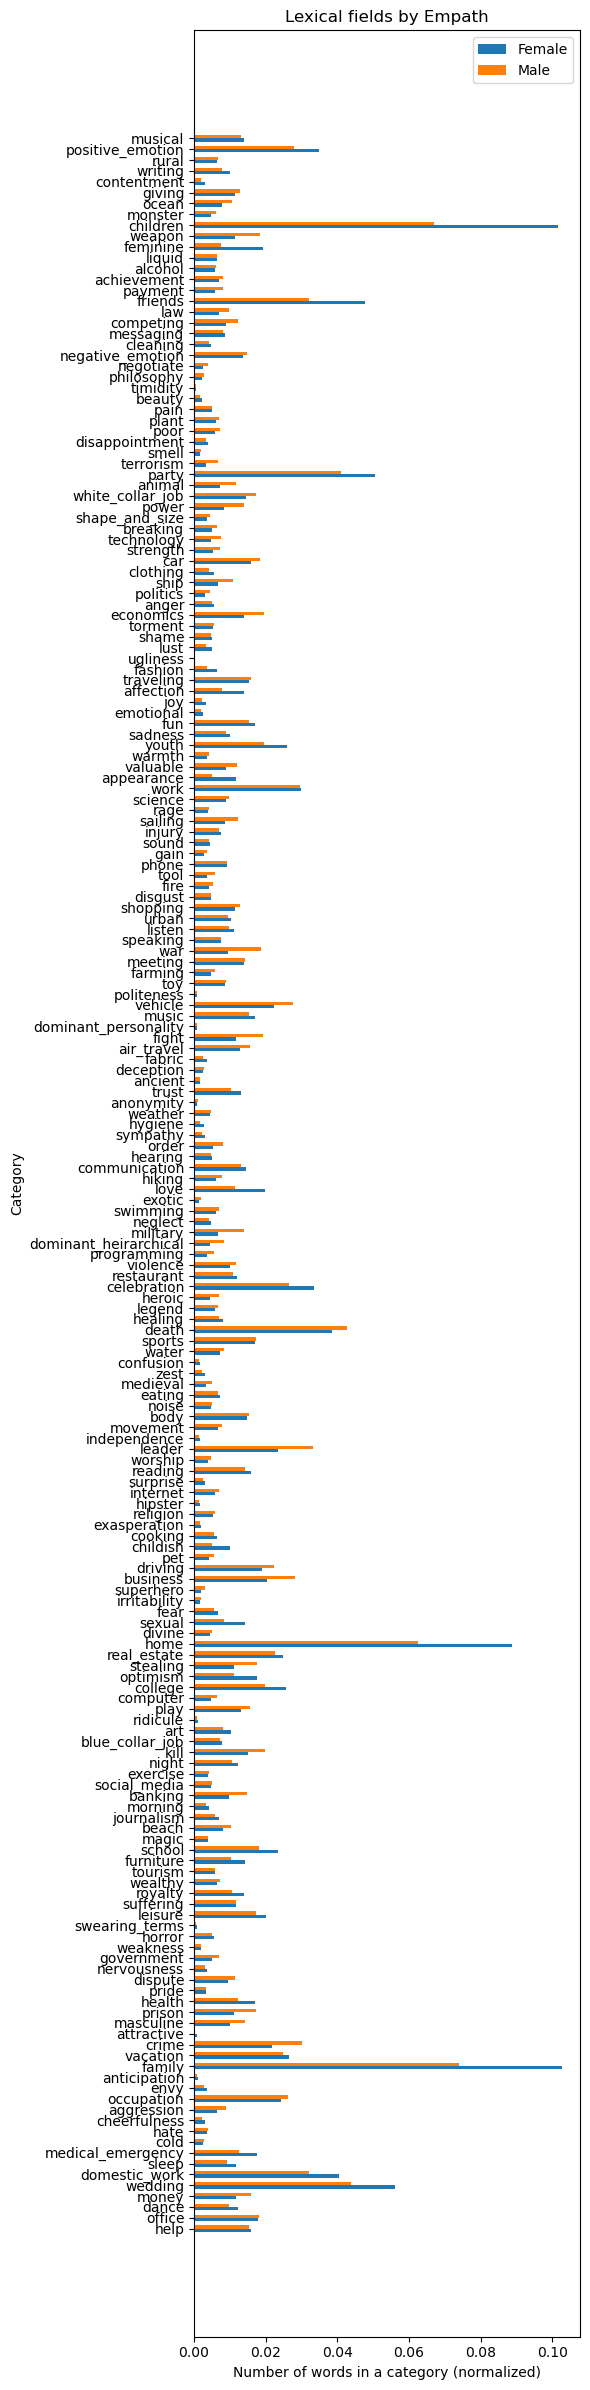

In [127]:
x = np.arange(df_category_NN.shape[0])  # the label locations
new_x = [10*i for i in x]
new_x = np.asanyarray(new_x)
width = 3  # the width of the bars

fig, ax = plt.subplots(figsize=(6,24))
rects1 = ax.barh(new_x - width/2, df_category_NN['Female'], width, align='center', label='Female')
rects2 = ax.barh(new_x + width/2, df_category_NN['Male'], width, align='center', label='Male')
ax.set_ylabel('Category')
ax.set_xlabel('Number of words in a category (normalized)')
ax.set_title('Lexical fields by Empath')
ax.set_yticks(new_x, df_category_NN.index)
ax.legend()
fig.tight_layout()

In [128]:
# only keep the once with a significant difference between men and women
df_cat_NN_difference = df_category_NN[abs(df_category_NN['Female']-df_category_NN['Male']) > 0.008]
df_cat_NN_difference =df_cat_NN_difference.reset_index()
cat_NN_list = df_cat_NN_difference['index'].to_list()

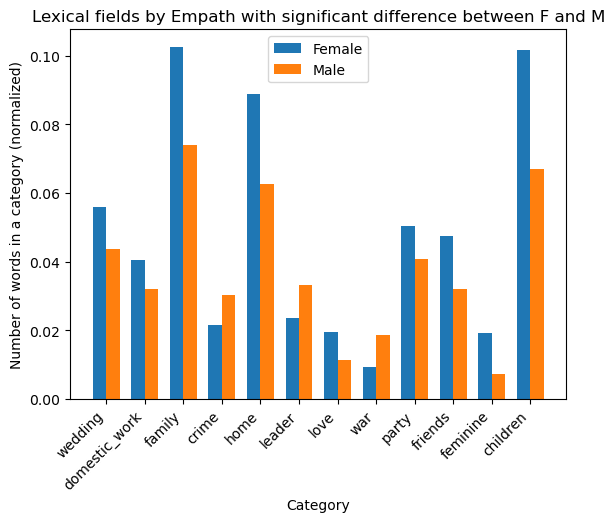

In [129]:
index = np.arange(df_cat_NN_difference.shape[0])
bar_width = 0.35

fig, ax = plt.subplots()
female = ax.bar(index, df_cat_NN_difference['Female'], bar_width,
                label="Female")

male = ax.bar(index+bar_width, df_cat_NN_difference['Male'],
                 bar_width, label="Male")

ax.set_xlabel('Category')
ax.set_ylabel('Number of words in a category (normalized)')
ax.set_title('Lexical fields by Empath with significant difference between F and M')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_cat_NN_difference['index'], rotation=45, ha='right')
ax.legend()

plt.show()

## Question 2.3: PCA

The goal of this research question is to examine the evolution of the representation of male and female characters in time. 

We first divide the M and F dataframes in three time periods (P):
- P1: release year < 1980
- P2: 1980 <= release year < 2000
- P3: 2000 < release year

In [130]:
summary_F_period1 = summary_all_clean_F[summary_all_clean_F['release_year']<1980]
print(f'Period 1 (<1980) contains {summary_F_period1.shape[0]} female character.')
summary_F_period2 = summary_all_clean_F[(summary_all_clean_F['release_year']>=1980) & 
                                       (summary_all_clean_F['release_year']<2000)]
print(f'Period 2 (1980 <= & < 2000) contains {summary_F_period2.shape[0]} female character.')
summary_F_period3 = summary_all_clean_F[summary_all_clean_F['release_year']>=2000]
print(f'Period 3 (>=2000) contains {summary_F_period3.shape[0]} female character.')

Period 1 (<1980) contains 3852 female character.
Period 2 (1980 <= & < 2000) contains 5003 female character.
Period 3 (>=2000) contains 9391 female character.


In [131]:
summary_M_period1 = summary_all_clean_M[summary_all_clean_M['release_year']<1980]
print(f'Period 1 (<1980) contains {summary_M_period1.shape[0]} male character.')
summary_M_period2 = summary_all_clean_M[(summary_all_clean_M['release_year']>=1980) & 
                                       (summary_all_clean_M['release_year']<2000)]
print(f'Period 2 (1980 <= & < 2000) contains {summary_M_period2.shape[0]} male character.')
summary_M_period3 = summary_all_clean_M[summary_all_clean_M['release_year']>=2000]
print(f'Period 3 (>=2000) contains {summary_M_period3.shape[0]} male character.')

Period 1 (<1980) contains 6581 male character.
Period 2 (1980 <= & < 2000) contains 9706 male character.
Period 3 (>=2000) contains 17496 male character.


For each gender and each time period, we perform the same empath analysis as for question 2.2. But this time however, we use all adjectives and nouns associated to a character.

In [132]:
lexicon = Empath()
df_category = []

df_category.append(lexicon.analyze((list_of_words(summary_M_period1,'JJ')+
                                    list_of_words(summary_M_period1,'NN')),
                                   normalize=True))
df_category.append(lexicon.analyze((list_of_words(summary_M_period2,'JJ')+
                                    list_of_words(summary_M_period2,'NN')),
                                   normalize=True))
df_category.append(lexicon.analyze((list_of_words(summary_M_period3,'JJ')+
                                    list_of_words(summary_M_period3,'NN')),
                                   normalize=True))

df_category.append(lexicon.analyze((list_of_words(summary_F_period1,'JJ')+
                                    list_of_words(summary_F_period1,'NN')),
                                   normalize=True))
df_category.append(lexicon.analyze((list_of_words(summary_F_period2,'JJ')+
                                    list_of_words(summary_F_period2,'NN')),
                                   normalize=True))
df_category.append(lexicon.analyze((list_of_words(summary_F_period3,'JJ')+
                                    list_of_words(summary_F_period3,'NN')),
                                   normalize=True))


# transform into a dataframe
df_category = pd.DataFrame(df_category, index = ['Male1','Male2','Male3',
                                                 'Female1','Female2','Female3'])

# delete lexical field with 0 for both F and M
df_category = df_category.loc[:, (df_category != 0).any(axis=0)]

df_category = df_category.copy().T

The correlation table gives the amount of linear relationship between the three periods of each gender.

In [74]:
df_category.corr()

,Male1,Male2,Male3,Female1,Female2,Female3
Male1,1.000000,0.983203,0.975897,0.920686,0.913761,0.905461
Male2,0.983203,1.000000,0.995421,0.929623,0.937766,0.934693
Male3,0.975897,0.995421,1.000000,0.942854,0.953401,0.952617
Female1,0.920686,0.929623,0.942854,1.000000,0.991136,0.985474
Female2,0.913761,0.937766,0.953401,0.991136,1.000000,0.997098
Female3,0.905461,0.934693,0.952617,0.985474,0.997098,1.000000


In [176]:
df_category.T

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Male1,0.012119,0.011958,0.007897,0.015020,0.033651,0.021838,0.007365,0.010830,0.003578,0.006527,...,0.015133,0.052152,0.006027,0.012442,0.009960,0.001708,0.005608,0.007671,0.022144,0.010750
Male2,0.012746,0.013590,0.008093,0.012577,0.033902,0.025144,0.006880,0.011860,0.003081,0.006690,...,0.013949,0.056841,0.006922,0.007977,0.010214,0.001614,0.005350,0.005687,0.024353,0.010604
Male3,0.012637,0.014607,0.007799,0.012148,0.035533,0.024995,0.007444,0.012305,0.002955,0.006424,...,0.015149,0.060580,0.006855,0.007560,0.009705,0.001673,0.006604,0.005234,0.025024,0.010545
Female1,0.012767,0.011679,0.010443,0.012767,0.048951,0.029212,0.008972,0.015768,0.003501,0.006560,...,0.008413,0.090048,0.004883,0.007796,0.009414,0.002942,0.006325,0.006237,0.030977,0.013032
Female2,0.012882,0.013401,0.009086,0.009356,0.042961,0.030370,0.009522,0.017674,0.003713,0.006887,...,0.009231,0.088205,0.005041,0.006120,0.007966,0.002323,0.007655,0.005497,0.029270,0.010414
Female3,0.013157,0.014364,0.010275,0.008296,0.043504,0.031424,0.009221,0.017408,0.003088,0.006307,...,0.009090,0.085921,0.004773,0.006046,0.009014,0.002588,0.007992,0.005110,0.029217,0.011558


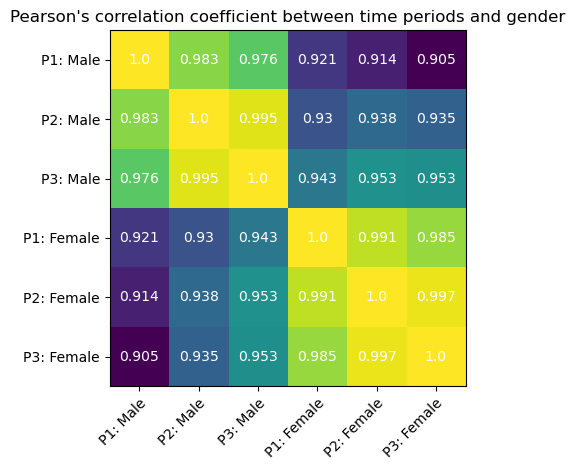

In [179]:
np_corr = df_category.corr().to_numpy()

fig, ax = plt.subplots()
im = ax.imshow(np_corr)

# Show all ticks and label them with the respective list entries
labels = ['P1: Male','P2: Male','P3: Male','P1: Female','P2: Female','P3: Female']
ax.set_xticks(np.arange(6), labels=labels)
ax.set_yticks(np.arange(6), labels=labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, np.around(np_corr[i, j],3),
                       ha="center", va="center", color="w")
        
ax.set_title("Pearson's correlation coefficient between time periods and gender")
fig.tight_layout()
plt.show()

fig.savefig("../corr_periods_gender.png")

In [144]:
from sklearn.decomposition import PCA

In [145]:
pca = PCA(n_components=2)
pca.fit(df_category.T)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.87556361 0.09083348]
[0.07537046 0.02427618]


In [178]:
res_PCA_2d

,Principal component 1,Principal component 2
0,0.039666,0.011894
1,0.029515,-0.005840
2,0.021810,-0.009101
3,-0.030836,0.015325
4,-0.029714,-0.002923
5,-0.030442,-0.009355


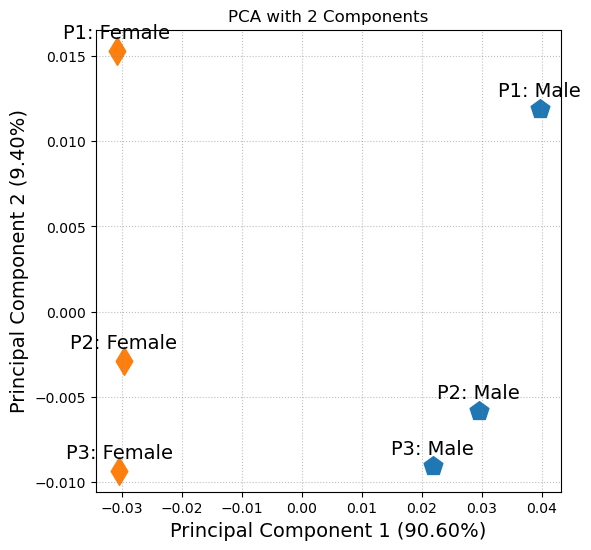

In [187]:
PCA_2d = PCA(n_components=2)
PCs_2 = PCA_2d.fit_transform(df_category.T)
res_PCA_2d = pd.DataFrame(data = PCs_2, columns = ['Principal component 1', 'Principal component 2'])
    
    #Visualize results 2D PCA
#    %matplotlib inline

    
pca = PCA().fit(PCs_2)
ratio = pca.explained_variance_ratio_
    
plt.figure(figsize=(6,6))
plt.xlabel('Principal Component 1 ({:.2%})'.format(ratio[0]) ,fontsize = 14)  
plt.ylabel('Principal Component 2 ({:.2%})'.format(ratio[1]),fontsize = 14)  
plt.title("PCA with 2 Components") 

plt.scatter(res_PCA_2d.loc[0:2,'Principal component 1'],
            res_PCA_2d.loc[0:2,'Principal component 2'],
            s = 200, marker='p')
plt.scatter(res_PCA_2d.loc[3:5,'Principal component 1'],
            res_PCA_2d.loc[3:5,'Principal component 2'],
            s = 200, marker='d')

#labels=['Female1','Female2','Female3','Male1','Male2','Male3']
for i in range(len(labels)):
    plt.annotate(labels[i],
                 (res_PCA_2d.loc[:,'Principal component 1'][i],
                  res_PCA_2d.loc[:,'Principal component 2'][i]+0.0005),
                 fontsize = 14, ha='center',va='bottom')

plt.grid()
plt.grid(ls=':', c='gray', alpha=0.5)
plt.show()

#fig.savefig("../PCA.png")

In [184]:
cat_list1 = ['love','war']
cat_list2 = ['beauty','social_media']
cat_list3 = ['work','domestic_work']
cat_list4 = ['power','heroic']
cat_list5 = ['alcohol','violence']
cat_list6 = ['family','friends']
cat_list7 = ['science','politics']
cat_list8 = ['positive_emotion','negative_emotion']
cat_list = ['love','crime',
            'beauty','social_media','domestic_work',
            'power','heroic',
            'science','politics']

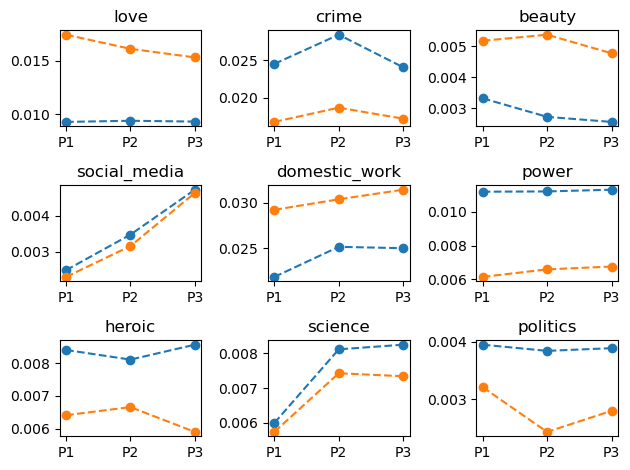

In [188]:
fig, ax = plt.subplots(3,3)


k=0
for i in range(3):
    for j in range(3):
        ax[i,j].plot(range(3),df_category[df_category.index==cat_list[k]].iloc[0][0:3],'o--',
                     label='Male')
        ax[i,j].plot(range(3),df_category[df_category.index==cat_list[k]].iloc[0][3:6],'o--',
                     label='Female')
        ax[i,j].set_title(cat_list[k])
        ax[i,j].set_xticks(range(3),labels=['P1','P2','P3'])
        k = k+1
        

plt.tight_layout()
#plt.legend()

#fig.savefig("../evolution_categories.png")